<h1 style="background-color:rgb(67, 194, 50); text-align: center"> Credit Risk Analysis System</h1>

**Objective**
This notebook aims to build a clean and analyzable dataset of corporate financial metrics sourced from the SEC EDGAR database. This data will later serve as the foundation for PowerBI reports capable of highlighting the company financial status and credit risk.
In this notebook, we perform ETL (Extract, Transform, Load) steps and EDA (Exploratory Data Analysis).

**Data Source**
We use publicly available data from the SEC EDGAR portal, specifically the Financial Statement and Notes Datasets: https://www.sec.gov/data-research/sec-markets-data/financial-statement-notes-data-sets.

These datasets include structured financial statements and explanatory notes submitted by publicly traded U.S. companies, typically as part of annual reports (10-K forms). The data is extracted directly from XBRL filings and organized into machine-readable tables.

Documentation of file structure, scope, and field definitions is provided in the official technical specification: https://www.sec.gov/files/dera/data/financial-statement-notes-data-sets/2025_02_notes.zip

These resources contain:
- Company identifiers (CIK, form type, filing date)
- Detailed financial metrics, including:
- Assets and liabilities
- Revenue, income, and earnings per share
- Cash flow statements
- Liquidity, solvency, and profitability ratios
- Footnotes and textual metadata that may indicate risk, uncertainty, or early signals of financial distress

The data is structured across several normalized tables such as sub.tsv, num.tsv, etc., which can be joined using common keys.

In [258]:
# %conda init
# %conda deactivate
# %conda activate credit-analysis-dashboard
# %conda install numpy pandas requests bs4 tqdm openai matplotlib seaborn 
# %conda install -c conda-forge ratelimit lxml statsmodels 
# %conda install conda-forge::nltk

In [259]:
import numpy as np
import pandas as pd
import os

In [260]:
# !pip install scikit-learn


<h2 style="background-color: #ffd5cd; text-align: center">ELT-Extract</h2>

In [261]:
# import requests
# from zipfile import ZipFile, BadZipFile
# from datetime import datetime

# # Base URL for the reports
# base_url = "https://www.sec.gov/files/dera/data/financial-statement-notes-data-sets/{}_02_notes.zip"

# # Local directory to save the files
# local_dir = "C:/Users/natal/credit-analysis-dashboard-v1/data/raw/"

# # Current year
# current_year = datetime.now().year

# # Iterate over the last 10 years
# for year in range(current_year - 10, current_year):
#     url = base_url.format(year)
#     local_filename = f"{local_dir}{year}_02_notes.zip"

#     # Download the file
#     headers = {
#         "User-Agent": "NataliaStekolnikova-FinRiskApp/1.0 (natalia.a.stekolnikova@gmail.com)",
#         "Accept-Encoding": "gzip, deflate",
#         "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
#         "Connection": "keep-alive",
#         "Host": "www.sec.gov",  # Add the Host header
#         "Referer": "https://www.sec.gov/",  # Add a Referer header
#         "From": "natalia.a.stekolnikova@gmail.com"  # Replace with your email address
#     }
#     response = requests.get(url, headers=headers, stream=True)
#     if response.status_code == 200:
#         with open(local_filename, "wb") as f:
#             for chunk in response.iter_content(chunk_size=8192):
#                 f.write(chunk)
#         print(f"Downloaded: {local_filename}")

#         # Extract the zip
#         try:
#             with ZipFile(local_filename, 'r') as zip_ref:
#                 extract_path = f"{local_dir}{year}_02_notes/"
#                 zip_ref.extractall(extract_path)
#                 print(f"Extracted to {extract_path}")
#         except BadZipFile:
#             print(f"Error: The downloaded file for {year} is not a valid ZIP file.")
#     else:
#         print(f"Failed to download file for {year}. Status code: {response.status_code}")

<h2 style="background-color: #ffd5cd; text-align: center">ELT-Load</h2>

### Overview: SEC Financial Statement Data — File Utility for Predictive Modeling

| File        | Description                                                                                      | Use for Modeling                                                               |
|-------------|--------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| `num.tsv`   | Contains actual **financial values** (e.g., revenue, net income, assets, liabilities).           | **Core dataset** for training features and targets.                           |
| `sub.tsv`   | Metadata: company ID (CIK), name, SIC, reporting period, form type (10-K, 10-Q), etc.            | Used to **filter and contextualize** `num.tsv` data.                          |
| `tag.tsv`   | Dictionary of all tags: names, labels, definitions, and whether standard or custom.              | Helps map tags to consistent financial concepts (e.g., revenue, income, etc). |
| `dim.tsv`   | Dimension info (e.g., data by business segments, geographic regions).                            | Used to **filter for consolidated data** or include segment-level details.    |
| `pre.tsv`   | Shows how line items appear in statements (e.g., order, section, label).                         | Useful for **resolving ambiguous/custom tags**.                               |
| `cal.tsv`   | Arithmetic relationships (e.g., which tags sum to totals).                                        | Optional: **reconstruct or validate missing/aggregated values**.              |
| `ren.tsv`   | Report rendering structure for display in SEC viewer.                                            | Not relevant for prediction modeling.                                       |
| `txt.tsv`   | Text blocks (e.g., accounting policies, risk notes, disclosures).                                 | Only useful for **NLP-based analysis**, not for numeric modeling.          |


In [262]:
# Define the years of interest
years_of_interest = [2024]

# Define the input directory template
DATA_INPUT_DIR_TEMPLATE = "C:/Users/natal/credit-analysis-dashboard-v1/data/raw/{}_02_notes/"

# List of file names to load
file_names = ["sub", "num", "tag", "cal", "dim", "pre", "ren", "txt"]

# Initialize a dictionary to store DataFrames for each year
dataframes_by_year = {}

# Iterate over the years of interest
for year in years_of_interest:
    # Format the input directory for the current year
    year_input_dir = DATA_INPUT_DIR_TEMPLATE.format(year)
    
    if os.path.exists(year_input_dir):
        # Load each .tsv file into a DataFrame and store it in the dictionary
        dataframes_by_year[year] = {
            file_name: pd.read_csv(
                os.path.join(year_input_dir, f"{file_name}.tsv"), 
                sep='\t', 
                low_memory=False
            )
            for file_name in file_names
        }
        print(f"Data for year {year} loaded successfully from {year_input_dir}")
    else:
        print(f"Directory for year {year} does not exist: {year_input_dir}")

# Concatenate data for each file type across all years
file_dataframes = {
    file_type: pd.concat(
        [dataframes_by_year[year][file_type] for year in years_of_interest if year in dataframes_by_year],
        ignore_index=True
    )
    for file_type in file_names
}

sub = file_dataframes['sub']
num = file_dataframes['num']
tag = file_dataframes['tag']
cal = file_dataframes['cal']
dim = file_dataframes['dim']
pre = file_dataframes['pre']
ren = file_dataframes['ren']
txt = file_dataframes['txt']


Data for year 2024 loaded successfully from C:/Users/natal/credit-analysis-dashboard-v1/data/raw/2024_02_notes/


In [263]:
# df2025 = pd.read_csv("C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_2025.csv")
# df2024 = pd.read_csv("C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_2024.csv")
# df2022 = pd.read_csv("C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_2022.csv")
# df2021 = pd.read_csv("C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary_2021.csv")

# # Combine all dataframes into one
# united_df = pd.concat([df2025, df2024, df2022, df2021], ignore_index=True)

# # Define the output file path
# output_file_path = "C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary.csv"

# # Export the united dataframe to a CSV file
# united_df.to_csv(output_file_path, index=False)

# print(f"Combined data exported successfully to {output_file_path}")
# # united_df[united_df['name'].str.contains('NVIDIA CORP', case=False, na=False)].head(10).transpose()

<h2 style="background-color: #ffd5cd; text-align: center">Exploratory Data Analysis (EDA)</h2>

In [264]:
sub.tail(5).transpose()

,9395,9396,9397,9398,9399
adsh,0001999371-24-002923,0001999371-24-002926,0001999371-24-002930,0001999371-24-002937,0002003881-24-000006
cik,1459862,1460235,1450922,1483386,2003881
name,ABRDN PALLADIUM ETF TRUST,ABRDN PLATINUM ETF TRUST,ABRDN SILVER ETF TRUST,ABRDN PRECIOUS METALS BASKET ETF TRUST,"STIRLING HOTELS & RESORTS, INC."
sic,6221.0,6221.0,6221.0,6221.0,6798.0
countryba,US,US,US,US,US
stprba,PA,PA,PA,PA,TX
cityba,PHILADELPHIA,PHILADELPHIA,PHILADELPHIA,PHILADELPHIA,DALLAS
zipba,19103,19103,19103,19103,75254
bas1,C/O ABRDN,C/O ABRDN,C/O ABRDN,C/O ABRDN,14185 DALLAS PARKWAY
bas2,"1900 MARKET STREET, SUITE 200","1900 MARKET STREET, SUITE 200","1900 MARKET STREET, SUITE 200","1900 MARKET STREET, SUITE 200",SUITE 1200


In [265]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         9400 non-null   object 
 1   cik          9400 non-null   int64  
 2   name         9400 non-null   object 
 3   sic          9104 non-null   float64
 4   countryba    9392 non-null   object 
 5   stprba       8882 non-null   object 
 6   cityba       9391 non-null   object 
 7   zipba        9392 non-null   object 
 8   bas1         9392 non-null   object 
 9   bas2         3918 non-null   object 
 10  baph         9394 non-null   object 
 11  countryma    9384 non-null   object 
 12  stprma       8892 non-null   object 
 13  cityma       9383 non-null   object 
 14  zipma        9379 non-null   object 
 15  mas1         9381 non-null   object 
 16  mas2         3909 non-null   object 
 17  countryinc   8416 non-null   object 
 18  stprinc      7795 non-null   object 
 19  ein   

In [266]:
sub.describe()

,cik,sic,ein,changed,wksi,fye,period,fy,filed,prevrpt,detail,nciks,pubfloatusd,floatdate,floatmems
count,9.400000e+03,9104.000000,9.400000e+03,5.547000e+03,9400.000000,9357.000000,9.326000e+03,2900.000000,9.400000e+03,9400.000000,9400.000000,9400.000000,2.070000e+03,2.070000e+03,2070.000000
mean,1.267268e+06,4865.842267,4.427757e+08,2.007073e+07,0.166809,1116.048947,2.023713e+07,2023.202069,2.024022e+07,0.060213,0.318617,1.026915,1.672520e+13,2.023053e+07,1.031401
std,5.336760e+05,1985.683194,3.312618e+08,1.163439e+05,0.372825,258.699172,4.320367e+03,0.424170,8.714076e+00,0.237893,0.465965,0.255629,4.778770e+14,1.389613e+03,0.395088
min,1.750000e+03,100.000000,0.000000e+00,1.960020e+07,0.000000,120.000000,2.021123e+07,2021.000000,2.024020e+07,0.000000,0.000000,1.000000,0.000000e+00,2.020063e+07,1.000000
25%,9.243830e+05,2911.000000,1.406893e+08,1.998081e+07,0.000000,1231.000000,2.023123e+07,2023.000000,2.024021e+07,0.000000,0.000000,1.000000,7.620504e+08,2.023063e+07,1.000000
50%,1.393669e+06,4911.000000,3.920405e+08,2.009061e+07,0.000000,1231.000000,2.024013e+07,2023.000000,2.024022e+07,0.000000,0.000000,1.000000,2.138662e+09,2.023063e+07,1.000000
75%,1.698990e+06,6770.000000,8.126213e+08,2.017060e+07,0.000000,1231.000000,2.024023e+07,2023.000000,2.024023e+07,0.000000,1.000000,1.000000,7.483933e+09,2.023063e+07,1.000000
max,2.012326e+06,8900.000000,1.000000e+09,2.023122e+07,1.000000,1231.000000,2.024043e+07,2025.000000,2.024023e+07,1.000000,1.000000,8.000000,1.990066e+16,2.024063e+07,16.000000


In [267]:
num.head(5).transpose()

,0,1,2,3,4
adsh,0001288847-24-000012,0001558370-24-002208,0000831259-24-000011,0000950170-24-022519,0001505155-24-000013
tag,CashAndCashEquivalentsFairValueDisclosure,DebtSecuritiesAvailableForSaleContinuousUnreal...,DebtInstrumentUnamortizedDiscountPremiumAndDeb...,DebtInstrumentInterestRateStatedPercentage,DebtInstrumentCashInterestCostsPercent
version,us-gaap/2023,us-gaap/2023,us-gaap/2023,us-gaap/2023,0001505155-24-000013
ddate,20231231,20221231,20231231,20221231,20211231
qtrs,0,0,0,0,4
uom,USD,USD,USD,pure,pure
dimh,0xf1a3f7ab0ed5cabeb17982b56e2bd348,0x2ec5bd062194389885092fd6ee4cdf99,0x644fcede5f5b4922957054761702c354,0x47fd5eced1f31d7f51f9c49075c62a37,0x00000000
iprx,0,0,0,0,0
value,0.0,5138000.0,-1000000.0,0.0475,0.054
footnote,NaN,NaN,NaN,NaN,NaN


In [268]:
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5206929 entries, 0 to 5206928
Data columns (total 16 columns):
 #   Column    Dtype  
---  ------    -----  
 0   adsh      object 
 1   tag       object 
 2   version   object 
 3   ddate     int64  
 4   qtrs      int64  
 5   uom       object 
 6   dimh      object 
 7   iprx      int64  
 8   value     float64
 9   footnote  object 
 10  footlen   int64  
 11  dimn      int64  
 12  coreg     object 
 13  durp      float64
 14  datp      float64
 15  dcml      int64  
dtypes: float64(3), int64(6), object(7)
memory usage: 635.6+ MB


In [269]:
num.describe()

,ddate,qtrs,iprx,value,footlen,dimn,durp,datp,dcml
count,5.206929e+06,5.206929e+06,5.206929e+06,5.141002e+06,5.206929e+06,5.206929e+06,5.206929e+06,5.206929e+06,5.206929e+06
mean,2.022422e+07,1.682894e+00,1.095029e-01,7.281859e+11,5.283804e-01,1.024776e+00,3.220531e-03,2.977264e-02,1.786322e+03
std,1.155776e+04,2.001154e+00,5.334317e-01,3.966138e+14,2.464374e+01,1.049340e+00,2.778588e-02,1.515105e+00,9.090112e+03
min,1.986123e+07,0.000000e+00,0.000000e+00,-4.261655e+13,0.000000e+00,0.000000e+00,-4.986300e-01,-1.500000e+01,-3.276800e+04
25%,2.022123e+07,0.000000e+00,0.000000e+00,1.870000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.000000e+00
50%,2.022123e+07,0.000000e+00,0.000000e+00,4.181603e+06,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00
75%,2.023123e+07,4.000000e+00,0.000000e+00,9.900000e+07,0.000000e+00,2.000000e+00,1.095891e-02,0.000000e+00,-3.000000e+00
max,2.923093e+07,1.280000e+02,6.500000e+01,4.244000e+17,2.121900e+04,9.000000e+00,4.986310e-01,1.500000e+01,3.276700e+04


In [270]:
num['value'] = num['value'].fillna(0) * 10**num['dcml'].fillna(0)

In [271]:
num.head(5)

,adsh,tag,version,ddate,qtrs,uom,dimh,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
0,0001288847-24-000012,CashAndCashEquivalentsFairValueDisclosure,us-gaap/2023,20231231,0,USD,0xf1a3f7ab0ed5cabeb17982b56e2bd348,0,0.0,NaN,0,1,NaN,0.000000,0.0,-3
1,0001558370-24-002208,DebtSecuritiesAvailableForSaleContinuousUnreal...,us-gaap/2023,20221231,0,USD,0x2ec5bd062194389885092fd6ee4cdf99,0,0.0,NaN,0,1,NaN,0.000000,0.0,-3
2,0000831259-24-000011,DebtInstrumentUnamortizedDiscountPremiumAndDeb...,us-gaap/2023,20231231,0,USD,0x644fcede5f5b4922957054761702c354,0,-0.0,NaN,0,2,NaN,0.000000,0.0,-6
3,0000950170-24-022519,DebtInstrumentInterestRateStatedPercentage,us-gaap/2023,20221231,0,pure,0x47fd5eced1f31d7f51f9c49075c62a37,0,475.0,NaN,0,1,NaN,0.000000,0.0,4
4,0001505155-24-000013,DebtInstrumentCashInterestCostsPercent,0001505155-24-000013,20211231,4,pure,0x00000000,0,54.0,NaN,0,0,NaN,0.010959,0.0,3


In [272]:
tag.head(2)

,tag,version,custom,abstract,datatype,iord,crdr,tlabel,doc
0,A.5000EuroDenominatedNotesDue2033Member,0000059478-24-000065,1,1,member,NaN,NaN,.5000% Euro Denominated Notes Due 2033 [Member],.5000% Euro Denominated Notes Due 2033
1,A.C.SolucoesParaPiscinasLda.Member,0000945841-24-000021,1,1,member,NaN,NaN,"A.C. Solucoes para Piscinas, Lda. [Member]","A.C. Solucoes para Piscinas, Lda."


In [273]:
tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534846 entries, 0 to 534845
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tag       534846 non-null  object
 1   version   534846 non-null  object
 2   custom    534846 non-null  int64 
 3   abstract  534846 non-null  int64 
 4   datatype  502062 non-null  object
 5   iord      288412 non-null  object
 6   crdr      158653 non-null  object
 7   tlabel    534771 non-null  object
 8   doc       494011 non-null  object
dtypes: int64(2), object(7)
memory usage: 36.7+ MB


In [274]:
tag.describe()

,custom,abstract
count,534846.000000,534846.000000
mean,0.960641,0.460757
std,0.194448,0.498458
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [275]:
# the tag dataset is NOT useful for our analysis

In [276]:
cal.head(2)

,adsh,grp,arc,negative,ptag,pversion,ctag,cversion
0,0001299969-24-000006,3,1,1,Liabilities,us-gaap/2022,AccountsPayableAndAccruedLiabilitiesCurrent,us-gaap/2022
1,0001299969-24-000006,1,23,1,LiabilitiesCurrent,us-gaap/2022,AccountsPayableAndAccruedLiabilitiesCurrent,us-gaap/2022


In [277]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490773 entries, 0 to 490772
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   adsh      490773 non-null  object
 1   grp       490773 non-null  int64 
 2   arc       490773 non-null  int64 
 3   negative  490773 non-null  int64 
 4   ptag      490773 non-null  object
 5   pversion  490773 non-null  object
 6   ctag      490773 non-null  object
 7   cversion  490773 non-null  object
dtypes: int64(3), object(5)
memory usage: 30.0+ MB


In [278]:
cal.describe()

,grp,arc,negative
count,490773.000000,490773.00000,490773.000000
mean,10.195744,10.42161,0.617689
std,8.076099,9.87979,0.786423
min,1.000000,1.00000,-1.000000
25%,4.000000,3.00000,1.000000
50%,8.000000,7.00000,1.000000
75%,15.000000,15.00000,1.000000
max,62.000000,93.00000,1.000000


In [279]:
# the cal dataset could be useful if we need a mapping between previous tag and current tag
# but we don't need it for now

In [280]:
dim.head(5)

,dimhash,segments,segt
0,0xd5512c6d294aee40238efb1a36a733f6,LongTermContractForPurchaseOfElectricPower=DAE...,0
1,0x7dddba118a15f37c1be71048ab5a5c96,BusinessSegments=SouthernCompanyGas;ProductOrS...,0
2,0x338a503b5b214d006a405f47195ea432,BusinessSegments=ProteinSciences;,0
3,0xd82a31aac24e8c29254c4850169e5a12,CreditFacility=RevolvingCreditFacility;DebtIns...,0
4,0x1d0ed180f303d44362d9184ee734f486,BusinessAcquisition=BronxThree;Geographical=NY...,0


In [281]:
dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430719 entries, 0 to 430718
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   dimhash   430719 non-null  object
 1   segments  430718 non-null  object
 2   segt      430719 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.9+ MB


In [282]:
dim.describe()

,segt
count,430719.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [283]:
# the dim dataset is NOT useful for our analysis

In [284]:
pre.head(2)

,adsh,report,line,stmt,inpth,tag,version,prole,plabel,negating
0,0001398344-24-003837,1,40,NaN,0,AdditionalSecurities462b,dei/2022,label,Additional Securities. 462(b),0
1,0001398344-24-003837,1,37,NaN,0,AdditionalSecuritiesEffective413b,dei/2022,label,"Additional Securities Effective, 413(b)",0


In [285]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3349316 entries, 0 to 3349315
Data columns (total 10 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   adsh      object
 1   report    int64 
 2   line      int64 
 3   stmt      object
 4   inpth     int64 
 5   tag       object
 6   version   object
 7   prole     object
 8   plabel    object
 9   negating  int64 
dtypes: int64(4), object(6)
memory usage: 255.5+ MB


In [286]:
# the pre dataset is NOT useful for our analysis

In [287]:
ren.head(2)

,adsh,report,rfile,menucat,shortname,longname,roleuri,parentroleuri,parentreport,ultparentrpt
0,0001193125-24-021250,1,H,C,Document and Entity Information,100000 - Document - Document and Entity Inform...,http://www.caesars.com//20240131/taxonomy/role...,NaN,NaN,NaN
1,0001213900-24-008689,34,H,D,Fair Value Measurements (Details),033 - Disclosure - Fair Value Measurements (De...,http://www.spec.com/role/ScheduleofFinancialAs...,http://www.spec.com/role/FairValueMeasurements...,21.0,16.0


In [288]:
ren.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275353 entries, 0 to 275352
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   adsh           275353 non-null  object 
 1   report         275353 non-null  int64  
 2   rfile          275353 non-null  object 
 3   menucat        275353 non-null  object 
 4   shortname      275342 non-null  object 
 5   longname       275353 non-null  object 
 6   roleuri        275353 non-null  object 
 7   parentroleuri  80567 non-null   object 
 8   parentreport   80567 non-null   float64
 9   ultparentrpt   137233 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 21.0+ MB


In [289]:
# the ren dataset is NOT useful for our analysis

In [290]:
txt.tail(3)

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
678417,0002004032-24-000003,SolicitingMaterial,dei/2023,20240229,0,0,en-US,32767,0.0,8.0,0x00000000,0,NaN,0,5,5,NaN,0,c-1,false
678418,0002004032-24-000003,TradingSymbol,dei/2023,20240229,0,0,en-US,32767,0.0,8.0,0x00000000,0,NaN,0,3,3,NaN,0,c-1,MOS
678419,0002004032-24-000003,WrittenCommunications,dei/2023,20240229,0,0,en-US,32767,0.0,8.0,0x00000000,0,NaN,0,5,5,NaN,0,c-1,false


In [291]:
txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678420 entries, 0 to 678419
Data columns (total 20 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   adsh      678420 non-null  object 
 1   tag       678420 non-null  object 
 2   version   678420 non-null  object 
 3   ddate     678420 non-null  int64  
 4   qtrs      678420 non-null  int64  
 5   iprx      678420 non-null  int64  
 6   lang      678420 non-null  object 
 7   dcml      678420 non-null  int64  
 8   durp      678420 non-null  float64
 9   datp      678420 non-null  float64
 10  dimh      678420 non-null  object 
 11  dimn      678420 non-null  int64  
 12  coreg     7113 non-null    object 
 13  escaped   678420 non-null  int64  
 14  srclen    678420 non-null  int64  
 15  txtlen    678420 non-null  int64  
 16  footnote  397 non-null     object 
 17  footlen   678420 non-null  int64  
 18  context   678420 non-null  object 
 19  value     677263 non-null  object 
dtypes: f

txt dataset can be useful for our analysis only if we want to extract some additional or specific Fields from a certain financial report.

<h1 style="background-color: #ffd5cd; text-align: center"> ELT-Transforming</h1>

# Let's start our analysis with the most useful sub and num datasets.

## Explanation of Technical Columns in SEC `num.tsv` / XBRL Data

The following table explains the meaning of some of the more technical columns found in the `num.tsv` file or in XBRL filings from the SEC:

| Column    | Meaning                                                                                     |
|-----------|----------------------------------------------------------------------------------------------|
| `footnote` | Textual note (if any) related to the numeric fact — e.g., exceptions or calculation notes. |
| `footlen`  | Length of the footnote text (in characters). Useful for filtering facts with annotations.   |
| `coreg`    | Co-registrant identifier (if the fact is filed jointly with another company).              |
| `qtrs`     | Number of fiscal quarters covered by the fact. `0 = instant`, `1 = quarter`, `4 = year`, etc. |
| `iprx`     | Internal SEC flag for whether the fact is used as an input in derived calculations.         |
| `dimn`     | Number of XBRL dimensions applied (e.g., by region, business segment, etc.).                |
| `durp`     | Duration of the period (in years or fractions). E.g., `0.25` means one quarter.             |
| `datp`     | Indicates what type of date applies: `1 = instant`, `3 = interval`, `-4 = period end`, etc. |
| `dcml`     | Decimal precision: `-3` means values are in thousands, `0` means no scaling, `32767` = unknown. |


In [292]:
num_filtered = num.drop(columns=['footnote', 'coreg', 'iprx', 'footlen', 'durp', 'datp'])
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5206929 entries, 0 to 5206928
Data columns (total 10 columns):
 #   Column   Dtype  
---  ------   -----  
 0   adsh     object 
 1   tag      object 
 2   version  object 
 3   ddate    int64  
 4   qtrs     int64  
 5   uom      object 
 6   dimh     object 
 7   value    float64
 8   dimn     int64  
 9   dcml     int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 397.3+ MB


In [293]:
# the following sub columns could be useful for our analysis:
sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']].head(4)

,adsh,cik,name,countryba,stprba,cityba,accepted,form,period,fy,fp
0,0000005272-24-000007,5272,"AMERICAN INTERNATIONAL GROUP, INC.",US,NY,NEW YORK,2024-02-01 16:24:00.0,8-K,20240131.0,NaN,NaN
1,0000008670-24-000007,8670,AUTOMATIC DATA PROCESSING INC,US,NJ,ROSELAND,2024-02-01 15:48:00.0,10-Q,20231231.0,2024.0,Q2
2,0000008947-24-000024,8947,AZZ INC,US,TX,FORT WORTH,2024-02-01 16:33:00.0,8-K,20240131.0,NaN,NaN
3,0000009389-24-000003,9389,BALL CORP,US,CO,WESTMINSTER,2024-02-01 08:17:00.0,8-K,20240131.0,NaN,NaN


In [294]:
# the following num columns could be useful for our analysis:
num_filtered[['adsh', 'tag', 'qtrs', 'dimn', 'value', 'version', 'ddate', 'uom']].head(5)

,adsh,tag,qtrs,dimn,value,version,ddate,uom
0,0001288847-24-000012,CashAndCashEquivalentsFairValueDisclosure,0,1,0.0,us-gaap/2023,20231231,USD
1,0001558370-24-002208,DebtSecuritiesAvailableForSaleContinuousUnreal...,0,1,0.0,us-gaap/2023,20221231,USD
2,0000831259-24-000011,DebtInstrumentUnamortizedDiscountPremiumAndDeb...,0,2,-0.0,us-gaap/2023,20231231,USD
3,0000950170-24-022519,DebtInstrumentInterestRateStatedPercentage,0,1,475.0,us-gaap/2023,20221231,pure
4,0001505155-24-000013,DebtInstrumentCashInterestCostsPercent,4,0,54.0,0001505155-24-000013,20211231,pure


In [295]:
columns_to_keep = ['adsh', 'tag', 'qtrs', 'dimn', 'value', 'version', 'ddate', 'uom']
num_filtered = num_filtered[columns_to_keep]
num_filtered.head(5)

,adsh,tag,qtrs,dimn,value,version,ddate,uom
0,0001288847-24-000012,CashAndCashEquivalentsFairValueDisclosure,0,1,0.0,us-gaap/2023,20231231,USD
1,0001558370-24-002208,DebtSecuritiesAvailableForSaleContinuousUnreal...,0,1,0.0,us-gaap/2023,20221231,USD
2,0000831259-24-000011,DebtInstrumentUnamortizedDiscountPremiumAndDeb...,0,2,-0.0,us-gaap/2023,20231231,USD
3,0000950170-24-022519,DebtInstrumentInterestRateStatedPercentage,0,1,475.0,us-gaap/2023,20221231,pure
4,0001505155-24-000013,DebtInstrumentCashInterestCostsPercent,4,0,54.0,0001505155-24-000013,20211231,pure


In [296]:
qtrs_count = num_filtered.groupby('qtrs').size()
print(qtrs_count)

qtrs
0      2812227
1       211443
2        70092
3        83753
4      2026326
        ...   
108          1
111         24
112          1
120          1
128          1
Length: 92, dtype: int64


## Interpretation of the `qtrs` Field in SEC `num.tsv`

The `qtrs` column in the `num.tsv` file indicates how many fiscal quarters are covered by the value of a financial metric. This helps interpret the time range over which the reported number is aggregated.

| `qtrs` | Meaning                               | Example Usage                                 |
|--------|----------------------------------------|-----------------------------------------------|
| 0      | Instant value (as of a date)           | For example, balance sheet items (`Assets`)   |
| 1      | One fiscal quarter                     | Quarterly revenue, net income                 |
| 2      | Two quarters (half-year)               | Semiannual reports, 6-K filings, etc.         |
| 3      | Three quarters                         | Cumulative 9-month data                       |
| 4      | Four quarters (full year)              | Annual 10-K filings, 10-Q with `FY` indicator |
| >4     | Extended or non-standard periods       | Possibly multi-year aggregations or anomalies |


In [297]:
num_filtered = num_filtered[num_filtered['qtrs'] <= 4]
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5203841 entries, 0 to 5206928
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   adsh     object 
 1   tag      object 
 2   qtrs     int64  
 3   dimn     int64  
 4   value    float64
 5   version  object 
 6   ddate    int64  
 7   uom      object 
dtypes: float64(1), int64(3), object(4)
memory usage: 357.3+ MB


In [298]:
# Extract unique tags from the 'tag' column of the 'num' DataFrame
unique_tags = num['tag'].unique()

# Export the unique_tags array to a CSV file
output_path = "C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/unique_tags.csv"
pd.DataFrame(unique_tags, columns=["Tag"]).to_csv(output_path, index=False, header=False)

print(f"Tags exported successfully to {output_path}")

Tags exported successfully to C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/unique_tags.csv


## Key Tags for Bank Analysis of Borrower's Solvency

| Category               | Important XBRL Tags                                                | Purpose                                                                 |
|------------------------|---------------------------------------------------------------------|-------------------------------------------------------------------------|
| Liquidity              | `AccountsReceivableNetCurrent`, `AccountsPayableCurrent`, `AccruedLiabilitiesCurrent` | Assessing the ability to cover short-term obligations                  |
| Current Liabilities    | `AccountsPayableCurrentAndNoncurrent`, `AccruedIncomeTaxesNoncurrent`          | Volume of debt and tax liabilities                                     |
| Cash Flow              | `AdjustmentForAmortization`, `AmortizationOfIntangibleAssets`, `NetCashProvidedByUsedInOperatingActivities` | Understanding available cash from core operations (essential for solvency) |
| Capital                | `AdditionalPaidInCapitalCommonStock`, `AccumulatedOtherComprehensiveIncomeLossNetOfTax`, `StockholdersEquity` | Evaluating capital adequacy and net worth                              |
| Asset Depreciation     | `AccumulatedDepreciationDepletionAndAmortization`                          | Assessing the aging or impairment of assets                            |
| Profitability          | `AllocatedShareBasedCompensationExpense`, `NetIncomeLoss`, `Revenues`       | Evaluating income generation and business efficiency                   |
| Total Position         | `Assets`                                                             | Overall size and strength of the company (total holdings and resources)|
| Acquisitions & Growth  | `AcquisitionsNetOfCashAcquiredAllOthers`                                     | Understanding recent expansion, M&A activity, and use of cash          |


In [299]:
# Let's start our analysis with the most useful sub and num datasets.
# the following sub columns could be useful for our analysis:
# sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']].head(1)
# the following num columns could be useful for our analysis:
# num[['adsh', 'tag', 'qtrs', 'dimn', 'value', 'version', 'ddate', 'uom']].head(1)

key_tags = {
    'NetIncomeLoss': 'Net Income',
    'Assets': 'Total Assets',
    'StockholdersEquity': 'Shareholder Equity',
    'NetCashProvidedByUsedInOperatingActivities': 'Cash From Ops',
    'Revenues': 'Revenue',
    'AccountsReceivableNetCurrent': 'Accounts Receivable (Current)',
    'AccountsPayableCurrent': 'Accounts Payable (Current)',
    'AccruedLiabilitiesCurrent': 'Accrued Liabilities (Current)',
    'AccumulatedDepreciationDepletionAndAmortization': 'Accumulated Depreciation/Amortization',
    'AdditionalPaidInCapitalCommonStock': 'Additional Paid-in Capital',
    'AmortizationOfIntangibleAssets': 'Amortization of Intangibles',
    'AllocatedShareBasedCompensationExpense': 'Share-based Compensation Expense'
}

num_filtered = num_filtered[num_filtered['tag'].isin(key_tags.keys())].copy()
num_filtered['metric_name'] = num_filtered['tag'].map(key_tags)
num_filtered = num_filtered.merge(sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']], on='adsh', how='left')

num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235161 entries, 0 to 235160
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adsh         235161 non-null  object 
 1   tag          235161 non-null  object 
 2   qtrs         235161 non-null  int64  
 3   dimn         235161 non-null  int64  
 4   value        235161 non-null  float64
 5   version      235161 non-null  object 
 6   ddate        235161 non-null  int64  
 7   uom          235161 non-null  object 
 8   metric_name  235161 non-null  object 
 9   cik          235161 non-null  int64  
 10  name         235161 non-null  object 
 11  countryba    235018 non-null  object 
 12  stprba       217518 non-null  object 
 13  cityba       235008 non-null  object 
 14  accepted     235161 non-null  object 
 15  form         235161 non-null  object 
 16  period       235143 non-null  float64
 17  fy           217464 non-null  float64
 18  fp           217464 non-

In [300]:
num_filtered = num_filtered.dropna(subset=['value', 'fy', 'fp'])
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217464 entries, 0 to 235160
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adsh         217464 non-null  object 
 1   tag          217464 non-null  object 
 2   qtrs         217464 non-null  int64  
 3   dimn         217464 non-null  int64  
 4   value        217464 non-null  float64
 5   version      217464 non-null  object 
 6   ddate        217464 non-null  int64  
 7   uom          217464 non-null  object 
 8   metric_name  217464 non-null  object 
 9   cik          217464 non-null  int64  
 10  name         217464 non-null  object 
 11  countryba    217321 non-null  object 
 12  stprba       202662 non-null  object 
 13  cityba       217311 non-null  object 
 14  accepted     217464 non-null  object 
 15  form         217464 non-null  object 
 16  period       217464 non-null  float64
 17  fy           217464 non-null  float64
 18  fp           217464 non-null 

In [301]:
num_filtered['ddate'] = pd.to_datetime(num_filtered['ddate'], format='%Y%m%d').dt.date
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217464 entries, 0 to 235160
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adsh         217464 non-null  object 
 1   tag          217464 non-null  object 
 2   qtrs         217464 non-null  int64  
 3   dimn         217464 non-null  int64  
 4   value        217464 non-null  float64
 5   version      217464 non-null  object 
 6   ddate        217464 non-null  object 
 7   uom          217464 non-null  object 
 8   metric_name  217464 non-null  object 
 9   cik          217464 non-null  int64  
 10  name         217464 non-null  object 
 11  countryba    217321 non-null  object 
 12  stprba       202662 non-null  object 
 13  cityba       217311 non-null  object 
 14  accepted     217464 non-null  object 
 15  form         217464 non-null  object 
 16  period       217464 non-null  float64
 17  fy           217464 non-null  float64
 18  fp           217464 non-null 

In [302]:
# Check for duplicates in the DataFrame
duplicate_count = num_filtered.duplicated().sum()

print(f"Number of duplicate rows in num_filtered: {duplicate_count}")

Number of duplicate rows in num_filtered: 119388


In [303]:
# Find duplicated rows
duplicated_rows = num_filtered[num_filtered.duplicated()]

# Display duplicated rows
duplicated_rows

,adsh,tag,qtrs,dimn,value,version,ddate,uom,metric_name,cik,name,countryba,stprba,cityba,accepted,form,period,fy,fp
144,0000875045-24-000009,Revenues,4,2,0.0,us-gaap/2023,2022-12-31,USD,Revenue,875045,BIOGEN INC.,US,MA,CAMBRIDGE,2024-02-13 17:41:00.0,10-K,20231231.0,2023.0,FY
228,0001493152-24-007974,NetIncomeLoss,1,0,0.0,us-gaap/2023,2022-03-31,USD,Net Income,1615063,"INSPIRED ENTERTAINMENT, INC.",US,NY,"NEW YORK,",2024-02-27 16:17:00.0,10-Q/A,20230331.0,2023.0,Q1
349,0001587523-24-000017,Revenues,4,0,0.0,us-gaap/2023,2022-12-31,USD,Revenue,1587523,KNOWLES CORP,US,IL,ITASCA,2024-02-21 16:45:00.0,10-K,20231231.0,2023.0,FY
462,0000089800-24-000033,StockholdersEquity,0,1,0.0,us-gaap/2023,2020-12-31,USD,Shareholder Equity,89800,SHERWIN WILLIAMS CO,US,OH,CLEVELAND,2024-02-20 15:58:00.0,10-K,20231231.0,2023.0,FY
490,0000715072-24-000042,StockholdersEquity,0,1,0.0,us-gaap/2023,2020-12-31,USD,Shareholder Equity,715072,RENASANT CORP,US,MS,TUPELO,2024-02-23 16:16:00.0,10-K,20231231.0,2023.0,FY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235151,0001628280-24-006385,NetIncomeLoss,4,1,0.0,us-gaap/2023,2021-12-31,USD,Net Income,1320414,SELECT MEDICAL HOLDINGS CORP,US,PA,MECHANICSBURG,2024-02-22 16:34:00.0,10-K,20231231.0,2023.0,FY
235155,0000092122-24-000009,Revenues,4,1,0.0,us-gaap/2023,2023-12-31,USD,Revenue,92122,SOUTHERN CO,US,GA,ATLANTA,2024-02-14 17:45:00.0,10-K,20231231.0,2023.0,FY
235157,0000950170-24-016553,AllocatedShareBasedCompensationExpense,4,1,0.0,us-gaap/2023,2023-12-31,USD,Share-based Compensation Expense,1526520,"TRIPADVISOR, INC.",US,MA,NEEDHAM,2024-02-16 17:21:00.0,10-K,20231231.0,2023.0,FY
235159,0000877860-24-000010,AllocatedShareBasedCompensationExpense,4,0,0.0,us-gaap/2023,2022-12-31,USD,Share-based Compensation Expense,877860,NATIONAL HEALTH INVESTORS INC,US,TN,MURFREESBORO,2024-02-20 16:12:00.0,10-K,20231231.0,2023.0,FY


In [304]:
# Remove duplicate rows from the num_filtered DataFrame
num_filtered = num_filtered.drop_duplicates()

In [305]:
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98076 entries, 0 to 235158
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         98076 non-null  object 
 1   tag          98076 non-null  object 
 2   qtrs         98076 non-null  int64  
 3   dimn         98076 non-null  int64  
 4   value        98076 non-null  float64
 5   version      98076 non-null  object 
 6   ddate        98076 non-null  object 
 7   uom          98076 non-null  object 
 8   metric_name  98076 non-null  object 
 9   cik          98076 non-null  int64  
 10  name         98076 non-null  object 
 11  countryba    97979 non-null  object 
 12  stprba       91139 non-null  object 
 13  cityba       97974 non-null  object 
 14  accepted     98076 non-null  object 
 15  form         98076 non-null  object 
 16  period       98076 non-null  float64
 17  fy           98076 non-null  float64
 18  fp           98076 non-null  object 
dtypes: float

In [306]:
# Select numerical columns
numerical_columns = num_filtered.select_dtypes(include=['float64', 'int64']).columns

# Initialize a dictionary to store outliers
outliers = {}

# Detect outliers using the IQR method
for column in numerical_columns:
    Q1 = num_filtered[column].quantile(0.01)
    Q3 = num_filtered[column].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers[column] = num_filtered[(num_filtered[column] < lower_bound) | (num_filtered[column] > upper_bound)]

# Display outliers for each column
for column, outlier_data in outliers.items():
    print(f"Outliers in column '{column}':")

Outliers in column 'qtrs':
Outliers in column 'dimn':
Outliers in column 'value':
Outliers in column 'cik':
Outliers in column 'period':
Outliers in column 'fy':


In [307]:
# Check for duplicates in the original long-format data (before pivot)
dupes_before = num_filtered.duplicated(
    subset=['cik', 'name', 'adsh', 'fy', 'fp', 'form', 'dimn', 'metric_name']
).sum()

print(f"Duplicates before pivot (same metric per group): {dupes_before}")

edf = num_filtered.pivot_table(
    index=['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp'],
    columns='metric_name',
    values='value',
).reset_index()

# Check for duplicates in the resulting pivoted table
dupes_after = edf.duplicated(subset=['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']).sum()

print(f"Duplicates in pivoted edf (same company-report-period): {dupes_after}")

Duplicates before pivot (same metric per group): 65429
Duplicates in pivoted edf (same company-report-period): 0


In [308]:
edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2635 entries, 0 to 2634
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   adsh                              2635 non-null   object 
 1   cik                               2635 non-null   int64  
 2   name                              2635 non-null   object 
 3   countryba                         2635 non-null   object 
 4   stprba                            2635 non-null   object 
 5   cityba                            2635 non-null   object 
 6   accepted                          2635 non-null   object 
 7   form                              2635 non-null   object 
 8   period                            2635 non-null   float64
 9   fy                                2635 non-null   float64
 10  fp                                2635 non-null   object 
 11  Accounts Payable (Current)        1664 non-null   float64
 12  Accoun

In [309]:
edf['ROE'] = edf['Net Income'] / edf['Shareholder Equity'].replace(0, np.nan)
edf['ROA'] = edf['Net Income'] / edf['Total Assets'].replace(0, np.nan)
edf['ROI'] = edf['Net Income'] / (edf['Total Assets'] - edf['Accounts Payable (Current)']).replace(0, np.nan)

edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2635 entries, 0 to 2634
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   adsh                              2635 non-null   object 
 1   cik                               2635 non-null   int64  
 2   name                              2635 non-null   object 
 3   countryba                         2635 non-null   object 
 4   stprba                            2635 non-null   object 
 5   cityba                            2635 non-null   object 
 6   accepted                          2635 non-null   object 
 7   form                              2635 non-null   object 
 8   period                            2635 non-null   float64
 9   fy                                2635 non-null   float64
 10  fp                                2635 non-null   object 
 11  Accounts Payable (Current)        1664 non-null   float64
 12  Accoun

In [310]:
edf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
metric_name,,,,,,,,
cik,2635.0,1.176602e+06,5.469991e+05,1.800000e+03,8.825435e+05,1.306830e+06,1.615063e+06,1.999538e+06
period,2635.0,2.023129e+07,1.207420e+03,2.022063e+07,2.023123e+07,2.023123e+07,2.023123e+07,2.024013e+07
fy,2635.0,2.023203e+03,4.123112e-01,2.022000e+03,2.023000e+03,2.023000e+03,2.023000e+03,2.025000e+03
Accounts Payable (Current),1664.0,5.367030e+05,8.017487e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.659040e+08
Accounts Receivable (Current),1505.0,6.707579e+05,8.941928e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.991518e+08
Accrued Liabilities (Current),1050.0,4.850265e+05,5.988179e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.629160e+08
Additional Paid-in Capital,1046.0,6.226315e+06,5.733212e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.677669e+08
Amortization of Intangibles,1616.0,4.328483e+04,5.084940e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.159061e+07
Cash From Ops,2528.0,5.360900e+08,2.691635e+10,-2.140942e+08,0.000000e+00,0.000000e+00,0.000000e+00,1.353333e+12



### Financial Risk Flag Criteria

| Condition                             | Metric              | Threshold          | Reason / Interpretation                                                                 |
|--------------------------------------|---------------------|--------------------|------------------------------------------------------------------------------------------|
| `Current Ratio < 1`                  | Liquidity           | Less than 1        | Company may not be able to cover short-term liabilities with current assets              |
| `Debt to Equity > 2`                 | Leverage            | Greater than 2     | Indicates high reliance on debt, risk of over-leveraging                                 |
| `ROE < 0`                            | Profitability       | Less than 0        | Negative Return on Equity suggests destroying shareholder value                          |
| `ROI < 0`                            | Investment Return   | Less than 0        | Assets are not generating returns; inefficient use of capital                            |
| `Profit Margin < 0`                  | Operational Health  | Less than 0        | Core business is unprofitable                                                            |
| `Missing values in any metric`       | Data Completeness   | Any `NaN`          | Incomplete data makes risk assessment unreliable; treated as potentially risky           |

If **any one** of these conditions is true, the company is classified as **High Risk**.

In [311]:
# Add key financial ratios
edf['Current Ratio'] = edf['Accounts Receivable (Current)'] / edf['Accounts Payable (Current)']
edf['Debt to Equity'] = (edf['Total Assets'] - edf['Shareholder Equity']) / edf['Shareholder Equity']
edf['Profit Margin'] = edf['Net Income'] / edf['Revenue']
edf['Asset Turnover'] = edf['Revenue'] / edf['Total Assets']
edf['ROI'] = edf['Net Income'] / (edf['Total Assets'] - edf['Accounts Payable (Current)'])

edf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Set conditional risk classification
edf['Financial Risk Flag'] = (
    (edf['Current Ratio'] < 1) |
    (edf['Debt to Equity'] > 2) |
    (edf['ROE'] < 0) |
    (edf['ROI'] < 0) |
    (edf['Profit Margin'] < 0) |
    edf[['Current Ratio', 'Debt to Equity', 'ROE', 'ROI', 'Profit Margin']].isnull().any(axis=1)
)

# Assign risk category and create a flag
edf['Risk Category'] = edf['Financial Risk Flag'].map({True: 'High Risk', False: 'Low Risk'})
edf['Risk Flag'] = edf['Financial Risk Flag'].astype(int)

# Group and analyze by report type
summary = edf[['name', 'ROE', 'ROA', 'ROI', 'Current Ratio', 'Debt to Equity', 'Profit Margin', 'Risk Category']].round(2)

# Show distribution by risk category
risk_dist = edf['Risk Category'].value_counts()

# Display results
print("\n--- Financial Risk Distribution ---")
print(risk_dist)

print("\n--- List of non-Risky companies ---")
non_risky_summary = summary[summary['Risk Category'] == 'Low Risk'].head(10)
non_risky_summary



--- Financial Risk Distribution ---
Risk Category
High Risk    2632
Low Risk        3
Name: count, dtype: int64

--- List of non-Risky companies ---


metric_name,name,ROE,ROA,ROI,Current Ratio,Debt to Equity,Profit Margin,Risk Category
457,"ELECTROMED, INC.",0.03,0.01,0.01,19.53,1.53,0.03,Low Risk
1245,"JERASH HOLDINGS (US), INC.",0.02,0.02,0.02,1.31,0.18,0.07,Low Risk
1389,CARDINAL ETHANOL LLC,0.12,0.06,0.06,2.30,1.04,0.14,Low Risk


In [312]:
edf.tail(7).transpose()

,2628,2629,2630,2631,2632,2633,2634
metric_name,,,,,,,
adsh,0001992243-24-000066,0001993004-24-000006,0001999371-24-002921,0001999371-24-002923,0001999371-24-002926,0001999371-24-002930,0001999371-24-002937
cik,1992243,1993004,1450923,1459862,1460235,1450922,1483386
name,"FREYR BATTERY, INC. /DE/","NORTHWESTERN ENERGY GROUP, INC.",ABRDN GOLD ETF TRUST,ABRDN PALLADIUM ETF TRUST,ABRDN PLATINUM ETF TRUST,ABRDN SILVER ETF TRUST,ABRDN PRECIOUS METALS BASKET ETF TRUST
countryba,US,US,US,US,US,US,US
stprba,GA,SD,PA,PA,PA,PA,PA
cityba,NEWNAN,SIOUX FALLS,PHILADELPHIA,PHILADELPHIA,PHILADELPHIA,PHILADELPHIA,PHILADELPHIA
accepted,2024-02-29 16:06:00.0,2024-02-14 19:42:00.0,2024-02-29 15:05:00.0,2024-02-29 15:21:00.0,2024-02-29 15:31:00.0,2024-02-29 15:44:00.0,2024-02-29 16:08:00.0
form,10-K,10-K,10-K,10-K,10-K,10-K,10-K
period,20231231.0,20231231.0,20231231.0,20231231.0,20231231.0,20231231.0,20231231.0


In [313]:
# output_path = "C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/"
# output_file_path = os.path.join(output_path, f"financial_summary_{years_of_interest[0]}.csv")
# edf.to_csv(output_file_path, index=False)
# print(f"Saved: {output_file_path}")

<h2 style="background-color: #ffd5cd; text-align: center">Statistical Analysis</h2>

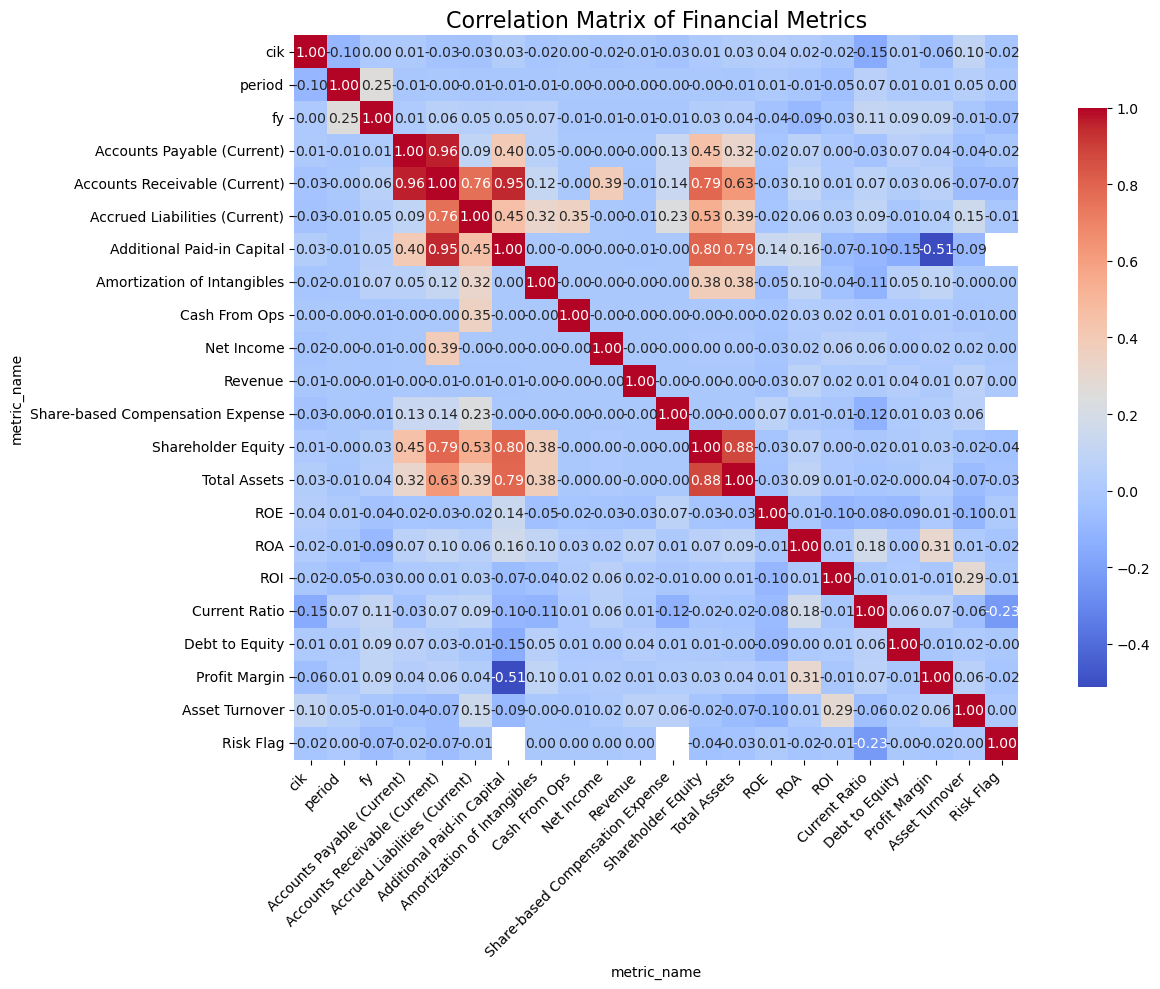

In [314]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove non-numeric columns before correlation
numeric_edf = edf.select_dtypes(include=['number', 'category'])

# Calculate correlation matrix
correlation_matrix = numeric_edf.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Financial Metrics", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


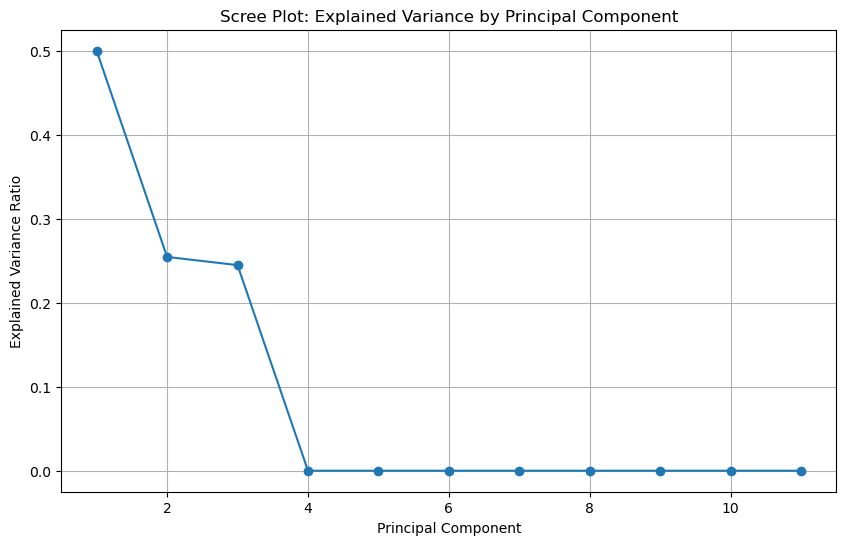

,PC,Explained Variance Ratio,Cumulative Variance
0,PC1,5.003489e-01,0.500349
1,PC2,2.547170e-01,0.755066
2,PC3,2.449341e-01,1.000000
3,PC4,3.543727e-33,1.000000
4,PC5,7.832377e-34,1.000000
5,PC6,1.257002e-35,1.000000
6,PC7,1.378827e-37,1.000000
7,PC8,6.393271e-67,1.000000
8,PC9,7.427146e-69,1.000000
9,PC10,2.894156e-100,1.000000


In [315]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = [
    'Net Income', 'Total Assets', 'Shareholder Equity', 'Cash From Ops', 'Revenue',
    'Accounts Receivable (Current)', 'Accounts Payable (Current)', 'Accrued Liabilities (Current)',
    'Additional Paid-in Capital', 
    'Amortization of Intangibles', 'Share-based Compensation Expense'
]

df = edf[features].dropna()

# Check if the DataFrame is empty after dropping missing values
if df.empty:
    raise ValueError("The DataFrame is empty after dropping rows with missing values. Ensure the selected features have sufficient data.")

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Apply PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

# Create a Scree plot (explained variance)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot: Explained Variance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Check how much variance is explained
explained_var = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Variance': pca.explained_variance_ratio_.cumsum()
})
explained_var.head(10)


### Explanation

- The first three components explain 100% of the variance.

- Components PC4 and onward explain virtually nothing — they are computational artifacts or reflect perfect multicollinearity in the data.

### Dimensionality Reduction is Highly Effective
You can safely reduce your data from 11 features to 3 principal components without losing any variance.

### Multicollinearity or Redundant Features Exist
Several original features are likely linear combinations of others (common in financial datasets where many metrics are derived).

### PC1 is Dominant
It captures half of all the variation — understanding what drives PC1 is critical (you’ve seen it's dominated by Share-based Compensation and Amortization of Intangibles).

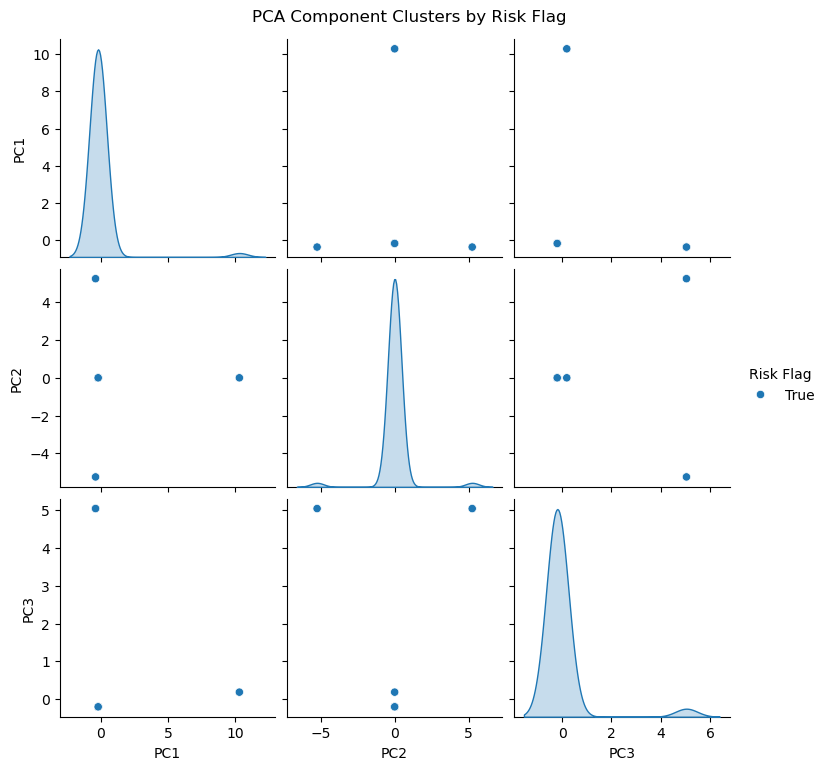

In [316]:
pca_df = pd.DataFrame(pca_data[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['Risk Flag'] = edf.loc[df.index, 'Financial Risk Flag'].values  # if using flag

sns.pairplot(pca_df, hue='Risk Flag', diag_kind='kde')
plt.suptitle('PCA Component Clusters by Risk Flag', y=1.02)
plt.show()

### Distribution Insights (Diagonals)

PC1: Wide spread with strong right skew (some risky companies show very large PC1 scores)

PC2 and PC3: Most values tightly clustered around 0, with some extreme outliers

In [317]:
loadings = pd.DataFrame(
    pca.components_.T[:, :3],
    columns=['PC1', 'PC2', 'PC3'],
    index=features
).sort_values(by='PC1', ascending=False)

display(loadings)

,PC1,PC2,PC3
Amortization of Intangibles,7.066236e-01,-1.759201e-16,2.613544e-02
Share-based Compensation Expense,7.066236e-01,-1.231872e-16,2.613544e-02
Accounts Payable (Current),3.215870e-47,4.622232e-33,-3.831675e-47
Net Income,0.000000e+00,-0.000000e+00,-0.000000e+00
Cash From Ops,0.000000e+00,-0.000000e+00,-0.000000e+00
Additional Paid-in Capital,-1.458519e-62,5.473822e-48,1.458519e-62
Accounts Receivable (Current),-3.831675e-47,-3.081488e-32,4.926440e-47
Shareholder Equity,-1.110223e-16,-2.982232e-17,1.110223e-16
Total Assets,-1.110223e-16,-7.706273e-17,1.110223e-16
Accrued Liabilities (Current),-2.613544e-02,7.071068e-01,7.066236e-01


This table shows how each original financial variable contributes to the first three Principal Components (PCs) extracted using PCA. Each component captures a direction of variance in your data.

| Feature                        | PC1    | PC2     | PC3    | Interpretation                            |
|-------------------------------|--------|---------|--------|--------------------------------------------|
| Amortization of Intangibles   | +0.707 | ~0      | +0.026 | Strongly defines PC1                       |
| Share-based Compensation      | +0.707 | ~0      | +0.026 | Strongly defines PC1       |
| Accrued Liabilities           | –0.026 | +0.707  | +0.707 | Defines PC2 and PC3 jointly                |
| Revenue                       | –0.026 | –0.707  | +0.707 | Opposite direction on PC2, aligns with PC3 |


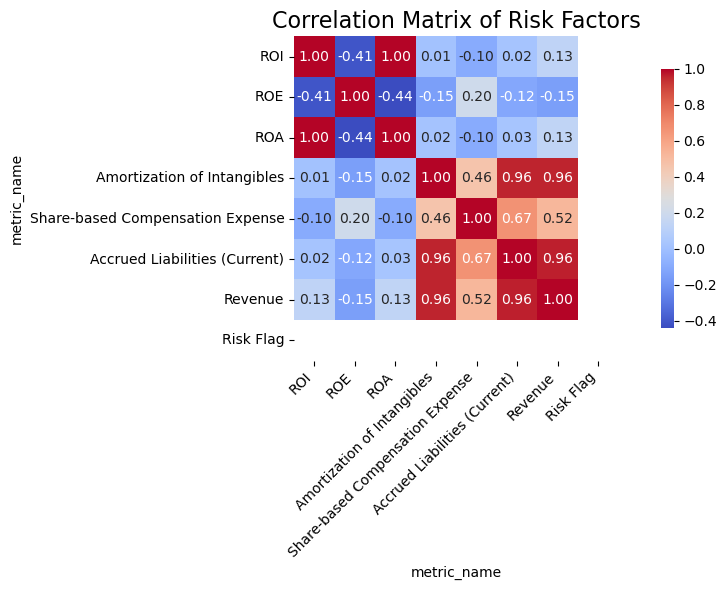

In [318]:
# Select only the metrics of interest
risk_factors = ['ROI', 'ROE', 'ROA', 'Amortization of Intangibles', 'Share-based Compensation Expense', 'Accrued Liabilities (Current)', 'Revenue', 'Risk Flag']

# Ensure the columns exist in the DataFrame
existing_factors = [factor for factor in risk_factors if factor in edf.columns]

# Filter the DataFrame, keeping only the specified metrics
filtered_edf = edf[existing_factors].dropna()

# Calculate the correlation matrix
correlation_matrix = filtered_edf.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Risk Factors", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Central Tendency for Feaures by Risk Category (With Outlier Control)
This analysis computes robust central tendency and dispersion statistics for key financial metrics across Low Risk and High Risk companies. To ensure results are not distorted by extreme values, the top and bottom 1% of outliers are removed based on each metric's overall distribution.

For each risk group and metric, the following statistics are calculated:
- Count (number of valid observations)
- Mean, Median, Mode
- Minimum and Maximum (within trimmed range)
- Standard Deviation

This breakdown enables a clear, side-by-side comparison of how financial health indicators vary across different levels of investment risk. It also supports further hypothesis testing, risk modeling, and visualization with a cleaner and more interpretable dataset.

In [319]:
# Metrics to evaluate
features = [
    'Current Ratio', 'Debt to Equity', 'ROE', 'ROA', 'ROI', 'Profit Margin'
]

df_valid = edf[features].dropna()

df_valid = edf.dropna(subset=['Risk Category'])

# Initialize list for results
summary_stats = []

# Loop over metrics and risk groups
for feature in features:
    # Calculate overall bounds for outlier removal
    lower = df_valid[feature].quantile(0.01)
    upper = df_valid[feature].quantile(0.99)

    for risk_group in ['Low Risk', 'High Risk']:
        group_data = df_valid[df_valid['Risk Category'] == risk_group][feature].dropna()
        
        # Remove outliers
        trimmed = group_data[(group_data >= lower) & (group_data <= upper)]

        stats = {
            'Metric': feature,
            'Risk Group': risk_group,
            'Count': len(trimmed),
            'Mean': round(trimmed.mean(), 2),
            'Median': round(trimmed.median(), 2),
            'Mode': round(trimmed.mode().iloc[0], 2) if not trimmed.mode().empty else 'N/A',
            'Min': round(trimmed.min(), 2),
            'Max': round(trimmed.max(), 2),
            'Std Dev': round(trimmed.std(), 2)
        }

        summary_stats.append(stats)

# Convert to DataFrame and display
summary_df = pd.DataFrame(summary_stats)

print("\n--- Central Tendency and Dispersion (Outliers Removed) ---\n")
print(summary_df.to_string(index=False))



--- Central Tendency and Dispersion (Outliers Removed) ---

        Metric Risk Group  Count   Mean  Median  Mode     Min   Max  Std Dev
 Current Ratio   Low Risk      3   7.71    2.30  1.31    1.31 19.53    10.24
 Current Ratio  High Risk     90   1.76    0.70  0.00    0.00 16.47     2.85
Debt to Equity   Low Risk      3   0.92    1.04  0.18    0.18  1.53     0.68
Debt to Equity  High Risk    269  -2.39    0.35 -1.00  -96.01 34.87    14.66
           ROE   Low Risk      3   0.06    0.03  0.02    0.02  0.12     0.05
           ROE  High Risk    269   0.28    0.04  0.00  -12.88 25.86     3.41
           ROA   Low Risk      3   0.03    0.02  0.01    0.01  0.06     0.02
           ROA  High Risk    283  -1.53   -0.10 -1.49  -57.79  0.31     5.54
           ROI   Low Risk      3   0.03    0.02  0.01    0.01  0.06     0.02
           ROI  High Risk    173  -0.23   -0.04 -0.00   -9.87  9.16     1.82
 Profit Margin   Low Risk      3   0.08    0.07  0.03    0.03  0.14     0.05
 Profit Margin 

## Key Observations by Metric

#### Current Ratio
| Risk Group | Mean | Median | Std Dev |
|------------|------|--------|---------|
| Low Risk   | 7.71 | 2.30   | 10.24   |
| High Risk  | 1.76 | 0.70   | 2.85    |

- **Low Risk** firms appear much more liquid, with a higher average and median.
- **High Risk** firms tend to operate close to or below a 1.0 current ratio — a sign of liquidity stress.

### Debt to Equity Analysis
| Group      | Mean  | Median | Std Dev |
|------------|-------|--------|---------|
| Low Risk   | 0.92  | 1.04   | 0.68    |
| High Risk  | -2.39 | 0.35   | 14.66   |

- **High Risk** firms show extreme variability (std = 14.66) and even negative values (likely due to negative equity).
- **Low Risk** firms have typical, modest leverage (~1.0), suggesting more balanced capital structures.

### Return on Investment (ROI)
| Group      | Mean   | Median | Std Dev |
|------------|--------|--------|---------|
| Low Risk   | 0.03   | 0.02   | 0.02    |
| High Risk  | -0.23  | -0.04  | 1.82    |

- **Low Risk** firms have modest, consistent returns.
- **High Risk** firms have negative average ROI and larger dispersion.

### Return on Equity (ROE)
| Group      | Mean  | Median | Std Dev |
|------------|-------|--------|---------|
| Low Risk   | 0.06  | 0.03   | 0.05    |
| High Risk  | 0.28  | 0.04   | 3.41    |

Median ROE is similar, but high-risk firms show much higher variability and extreme outliers (max = 25.86), likely due to volatile earnings or very low equity bases.

### Return on Assets (ROA)
| Group      | Mean   | Median | Std Dev |
|------------|--------|--------|---------|
| Low Risk   | 0.03   | 0.02   | 0.02    |
| High Risk  | -1.53  | -0.10  | 5.54    |

- **High Risk** firms on average destroy value on their assets (negative ROA).
- High standard deviation suggests operational instability or chronic losses.

### Profit Margin Analysis
| Risk Group | Mean    | Median | Std Dev  |
|------------|---------|--------|----------|
| Low Risk   | 0.08    | 0.07   | 0.05     |
| High Risk  | -30.90  | -0.78  | 123.37   |

Profit Margin is the most striking metric:

- **High Risk** firms have a massively negative average (-30.9%) and extreme outliers (min = -936%).
- This suggests many high-risk companies operate at heavy losses, likely with unstable cost structures or failing business models.

### Summary of Patterns

| Metric         | High Risk Firms Tend To Be...                                                                 |
|----------------|-----------------------------------------------------------------------------------------------|
| Current Ratio  | Less liquid (median near 0.7)                                                                |
| Debt to Equity | Highly variable, sometimes negative (unstable capital base)                                  |
| ROE, ROA, ROI  | Lower or negative returns, high volatility                                                   |
| Profit Margin  | Frequently unprofitable, with extreme losses in some cases                                   |

## Conclusions

- Debt to Equity, Profit Margin, and ROI are the most reliable indicators for distinguishing between high-risk and low-risk companies.
- Current Ratio and ROE show weaker differentiation and may not be sufficient on their own, but could still be useful in combination with other features.

# Dispersion and Percentile Analysis of Financial Metrics by Risk Group (With Outlier Removal)

This script calculates measures of dispersion and distribution shape for key financial indicators, segmented by Risk Category (Low vs. High Risk). To ensure robust comparisons, the analysis excludes extreme values by trimming data to the 1st–99th percentile range within each group.

For each metric and risk group, the following statistics are reported:
- Count, Min, Max, and Range
- Variance and Standard Deviation
- 25th, 50th (Median), and 75th percentiles

In [338]:
df_valid = edf.dropna(subset=['Risk Category'])

features = [
    'Net Income', 'Total Assets', 'Shareholder Equity', 'Cash From Ops', 'Revenue',
    'Accounts Receivable (Current)', 'Accounts Payable (Current)', 'Accrued Liabilities (Current)',
    'Additional Paid-in Capital', 
    'Amortization of Intangibles', 'Share-based Compensation Expense'
]

dispersion_stats_trimmed = []

for feature in features:
    for group in ['Low Risk', 'High Risk']:
        group_data = df_valid[df_valid['Risk Category'] == group][feature].dropna()

        # Remove outliers: keep values between 1st and 99th percentiles
        q1 = group_data.quantile(0.01)
        q99 = group_data.quantile(0.99)
        trimmed = group_data[(group_data >= q1) & (group_data <= q99)]

        stats = {
            'Metric': feature,
            'Risk Group': group,
            'Count': len(trimmed),
            'Min': round(trimmed.min(), 2),
            'Max': round(trimmed.max(), 2),
            'Range': round(trimmed.max() - trimmed.min(), 2),
            'Variance': round(trimmed.var(), 2),
            'Std Dev': round(trimmed.std(), 2),
            '25th Percentile': round(trimmed.quantile(0.25), 2),
            '50th Percentile (Median)': round(trimmed.quantile(0.5), 2),
            '75th Percentile': round(trimmed.quantile(0.75), 2),
        }

        dispersion_stats_trimmed.append(stats)

# Create DataFrame and display
dispersion_df_trimmed = pd.DataFrame(dispersion_stats_trimmed)

# Show the result
print("\n--- Measures of Dispersion by Risk Group (Outliers Removed) ---\n")
print(dispersion_df_trimmed.to_string(index=False))



--- Measures of Dispersion by Risk Group (Outliers Removed) ---

                          Metric Risk Group  Count         Min          Max        Range     Variance     Std Dev  25th Percentile  50th Percentile (Median)  75th Percentile
                      Net Income   Low Risk      1  1649584.75   1649584.75         0.00          NaN         NaN       1649584.75                1649584.75       1649584.75
                      Net Income  High Risk   2385 -7535770.33   6088400.00  13624170.33 4.009214e+11   633183.54             0.00                      0.00             0.00
                    Total Assets   Low Risk      1 80754663.00  80754663.00         0.00          NaN         NaN      80754663.00               80754663.00      80754663.00
                    Total Assets  High Risk   2597        0.00 236434199.50 236434199.50 3.480009e+14 18654783.18             0.00                      0.00             0.00
              Shareholder Equity   Low Risk      1 68189733.50  

## Dispersion and Distribution Analysis by Risk Category

This analysis compares the **spread and distribution** of core financial metrics across **Low Risk** and **High Risk** firms, using trimmed data (1st–99th percentiles) to eliminate the effect of outliers.

### Key Findings

#### 1. Extreme Asymmetry in Sample Sizes
- The **Low Risk group has only one valid record** for most metrics, and zero for some.
- This leads to **zero ranges and NaN variance**, making direct comparison unreliable.
- **All meaningful dispersion insights come from the High Risk group.**

#### 2. High Variability Among High Risk Companies

| Metric                        | Std Dev (High Risk) | Insight                                             |
|------------------------------|----------------------|-----------------------------------------------------|
| Net Income                   | `633,183`            | Earnings instability across firms                   |
| Total Assets                 | `18,654,783`         | Huge variation in scale                             |
| Shareholder Equity           | `4,114,786`          | Reflects financial imbalance, possibly negative equity |
| Revenue                      | `2,722,510`          | Wide revenue scale across firms                     |
| Add'l Paid-in Capital        | `9,055,057`          | Varies by capital structure                         |
| Share-based Comp. Expense    | `152,089`            | Likely linked to growth stage or executive policies |

**Conclusion:**  
High Risk firms are **heterogeneous** and financially **volatile**, indicating wide-ranging business models and maturity levels.

#### 3. Metrics Heavily Skewed Toward Zero
- In High Risk firms, **many metrics have median = 0**.
- This includes **Net Income, Revenue, Cash From Ops, Accounts Payable**, etc.

Indicates:
- A large portion of High Risk firms have **minimal or no financial activity**, or
- **Trimmed outliers dominate** what remains, pushing distributions to zero.

#### 4. Data Gaps in Low Risk Firms
- **No valid values** for:
  - Additional Paid-in Capital
  - Share-based Compensation Expense
- **Only one row available** for most other metrics

Suggests:
- Data sparsity
- Possibly fewer filings or surviving companies in the Low Risk category

### Overall Summary

| Theme                        | Insight                                                       |
|-----------------------------|---------------------------------------------------------------|
| **High Risk Dispersion**    | High variance, broad scale, unstable operations               |
| **Low Risk Sample**         | Too small for statistical reliability                         |
| **Zero-heavy Metrics**      | High Risk companies show limited or no financial activity     |
| **Takeaway**                | **High Risk = High variability and operational inconsistency** |

## Boxplot Visualization of Financial Features by Risk Category

This visualization script reshapes the dataset and creates a grouped boxplot to compare the distribution of key financial metrics across Low Risk and High Risk companies.

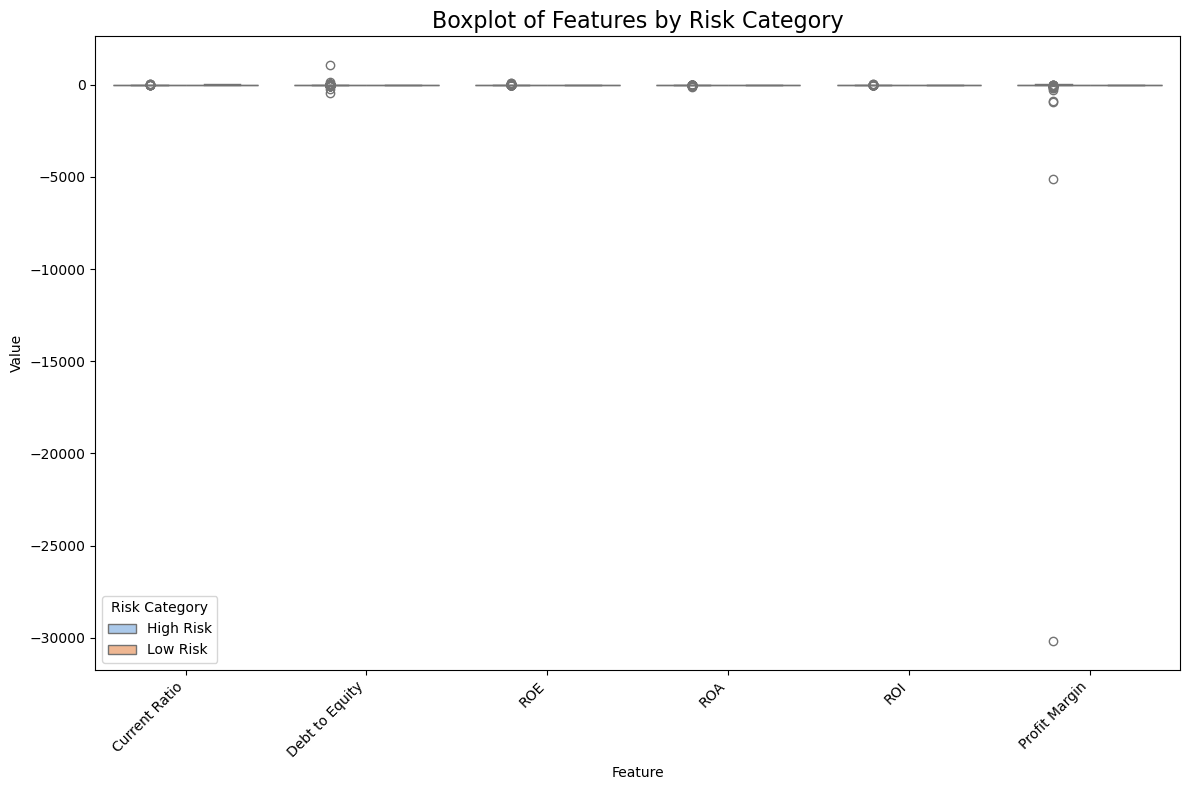

In [334]:
features = ['Current Ratio', 'Debt to Equity', 'ROE', 'ROA', 'ROI', 'Profit Margin']

# Prepare data for visualization
edf_melted = edf.melt(id_vars=['Risk Category'], value_vars=features, var_name='Feature', value_name='Value')

# Plot grouped boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=edf_melted, x='Feature', y='Value', hue='Risk Category', palette='pastel')
plt.title('Boxplot of Features by Risk Category', fontsize=16)
plt.ylabel('Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Risk Category')
plt.tight_layout()
plt.show()


## Interpretation: Boxplot of Financial Features by Risk Category

This grouped boxplot visualizes the distribution, spread, and central tendency of six key financial indicators segmented by Risk Category (High Risk vs. Low Risk).

### Feature-by-Feature Insights

**Current Ratio**  
- Low Risk firms show slightly higher medians and a broader interquartile range (IQR), indicating greater liquidity.  
- High Risk firms also display wide variability but with a noticeably lower tail, suggesting a group of firms with potential short-term solvency issues.

**Debt to Equity**  
- Both risk groups have similar medians and IQRs, with overlapping boxes.  
- Slightly higher spread for High Risk, hinting at greater leverage variability among these firms.

**ROE (Return on Equity)**  
- Low Risk firms cluster above zero, with higher median and lower spread.  
- High Risk firms show more spread below zero, indicating negative equity returns are more common.

**ROA (Return on Assets)**  
- Patterns are similar to ROE:  
  - Low Risk: Narrow and above zero.  
  - High Risk: Wider and skewed downward.  
- Suggests operational efficiency is less stable in high-risk firms.

**ROI (Return on Investment)**  
- High Risk firms exhibit larger spread and negative values.  
- Low Risk firms are more concentrated around positive ROI, indicating better investment returns.

**Profit Margin**  
- Both groups show outliers, but:  
  - Low Risk: Centered around positive margins.  
  - High Risk: Slight skew toward negative values, although medians are relatively close.


## Bar Charts: Top 10 Companies by Return on Equity (ROE)

This script filters the dataset to include only companies with valid **Return on Equity (ROE)** values, then selects the **top 10 performers** based on ROE.

A bar chart is generated to visualize these companies and their ROE scores, helping identify firms that generate the **highest return relative to shareholder equity**.

This analysis supports:
- Benchmarking **top-performing firms**
- Highlighting **capital-efficient** companies
- Informing **investment screening and profitability analysis**


C:\Users\natal\AppData\Local\Temp\ipykernel_32488\2326981076.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')


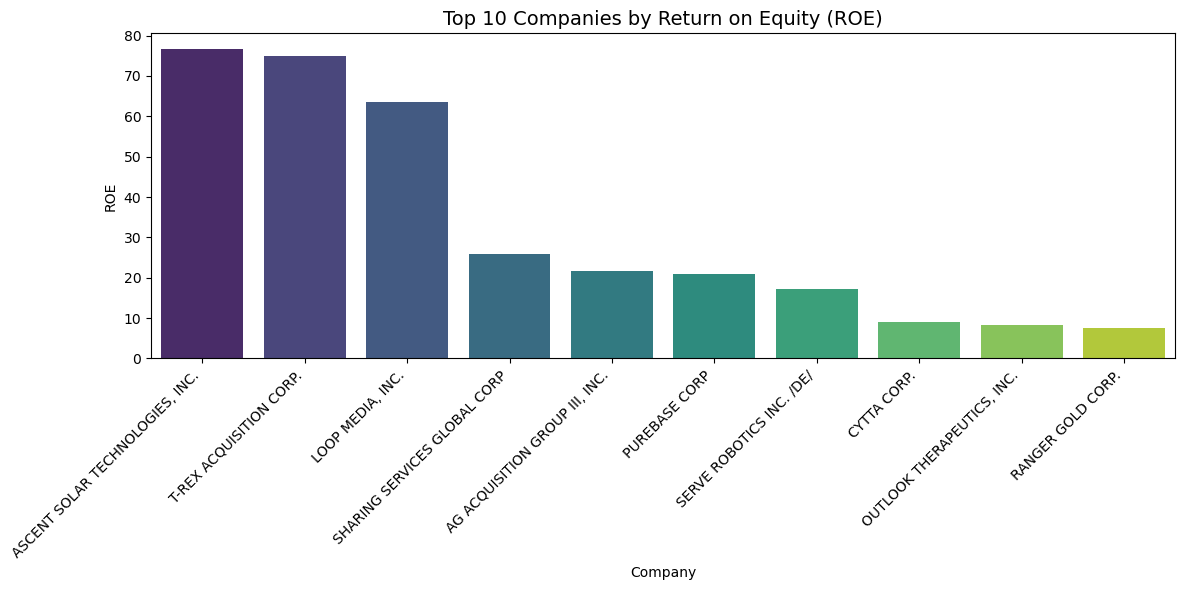

In [322]:

# Filter, drop NaNs, and select top 10 by ROE
top_10_roe = (
    edf.dropna(subset=['ROE'])
    .sort_values(by='ROE', ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')
plt.title('Top 10 Companies by Return on Equity (ROE)', fontsize=14)
plt.ylabel('ROE')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\natal\AppData\Local\Temp\ipykernel_32488\2751412124.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')


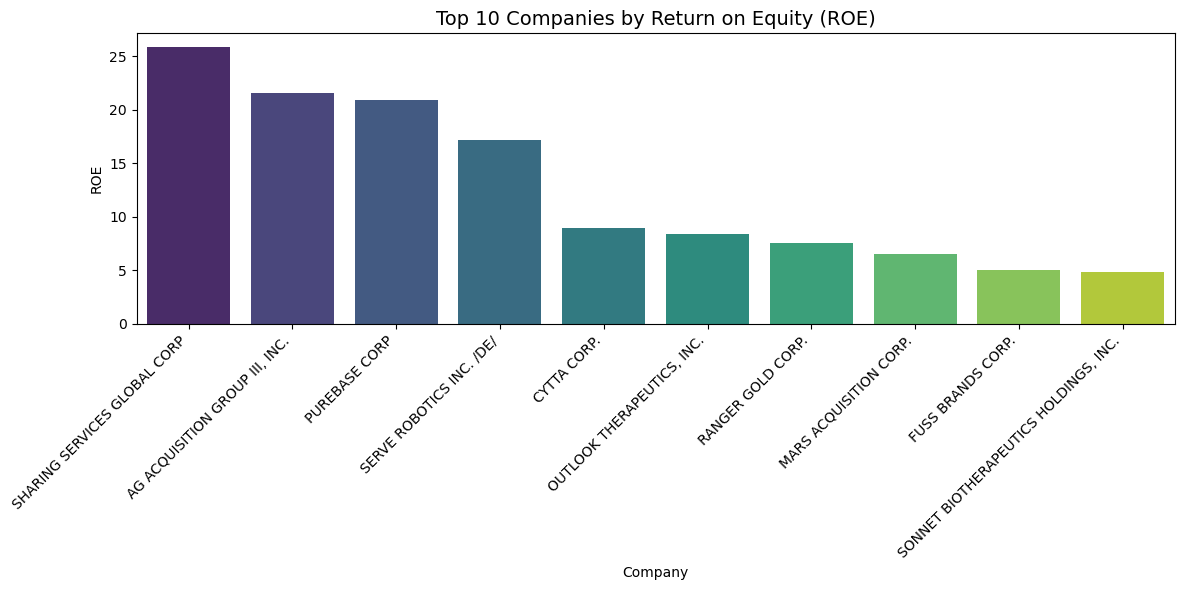

In [323]:
# --- Plot: Top 10 companies by ROE (excluding extreme outliers) ---
filtered_roe = edf.dropna(subset=['ROE'])
filtered_roe = filtered_roe[filtered_roe['ROE'] < filtered_roe['ROE'].quantile(0.99)]
top_10_roe = filtered_roe.sort_values(by='ROE', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')
plt.title('Top 10 Companies by Return on Equity (ROE)', fontsize=14)
plt.ylabel('ROE')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_32488\1315870465.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')


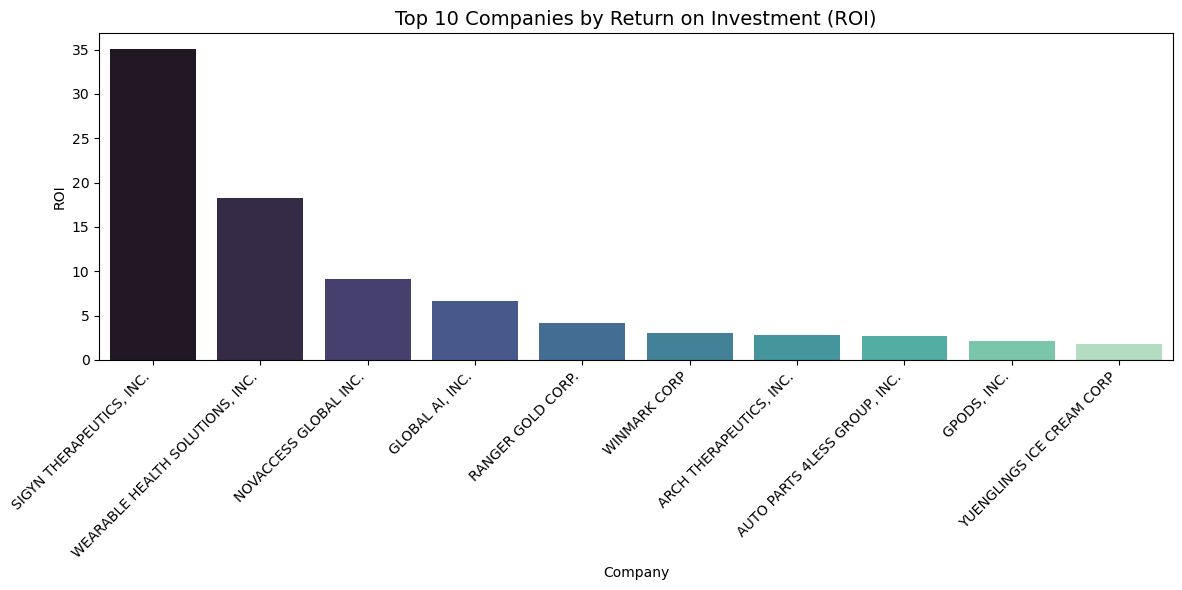

In [324]:
# --- Plot: Top 10 companies by ROI (excluding extreme outliers) ---
filtered_roi = edf.dropna(subset=['ROI'])
top_10_roi = filtered_roi.sort_values(by='ROI', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')
plt.title('Top 10 Companies by Return on Investment (ROI)', fontsize=14)
plt.ylabel('ROI')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_32488\1107599803.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')


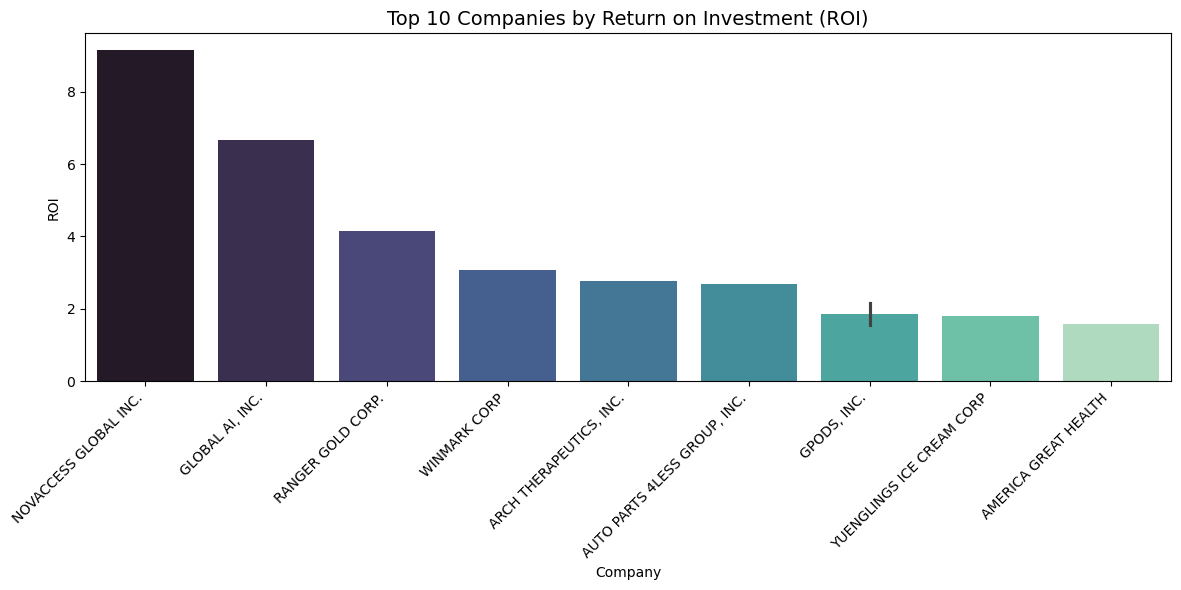

In [325]:
# --- Plot: Top 10 companies by ROI (excluding extreme outliers) ---
filtered_roi = edf.dropna(subset=['ROI'])
filtered_roi = filtered_roi[filtered_roi['ROI'] < filtered_roi['ROI'].quantile(0.99)]
top_10_roi = filtered_roi.sort_values(by='ROI', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')
plt.title('Top 10 Companies by Return on Investment (ROI)', fontsize=14)
plt.ylabel('ROI')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Staitstical Analysis

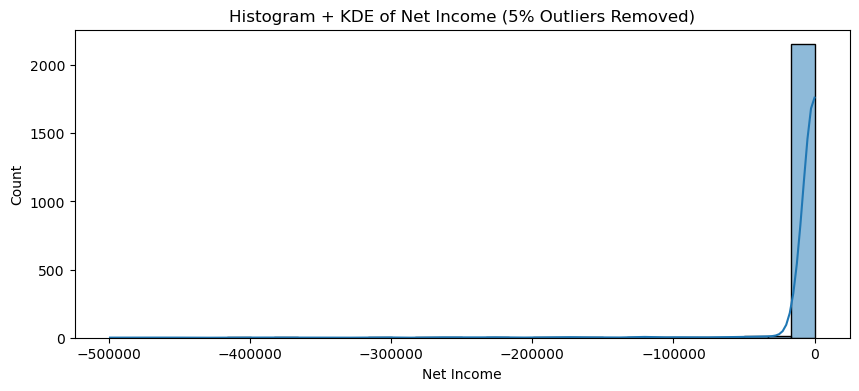

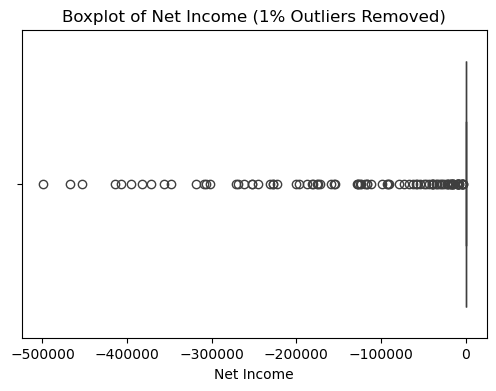

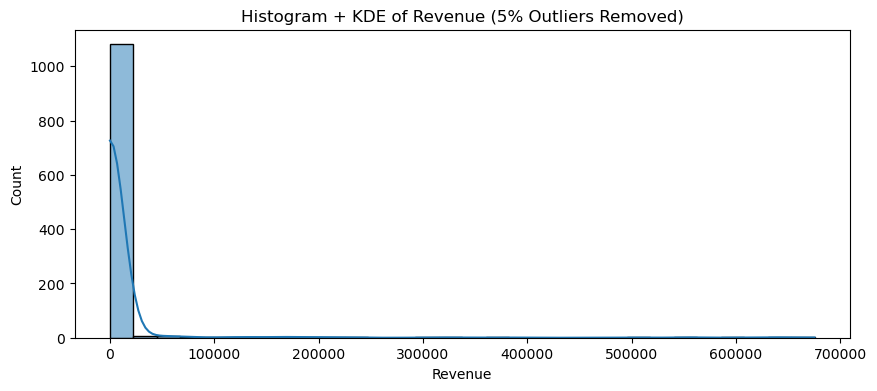

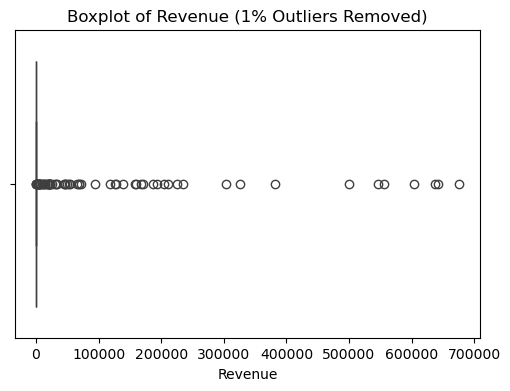

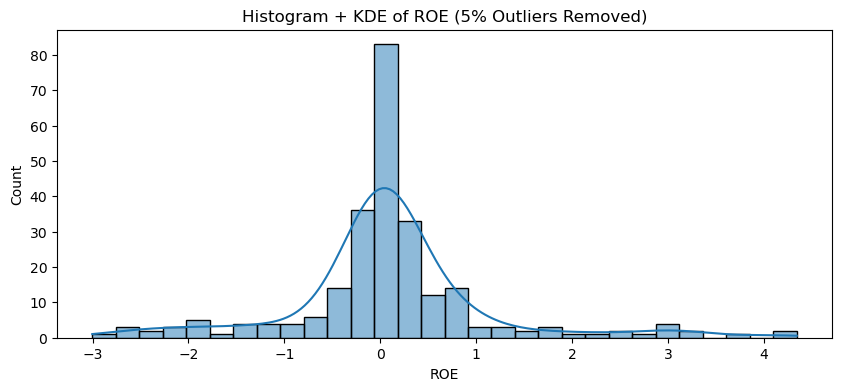

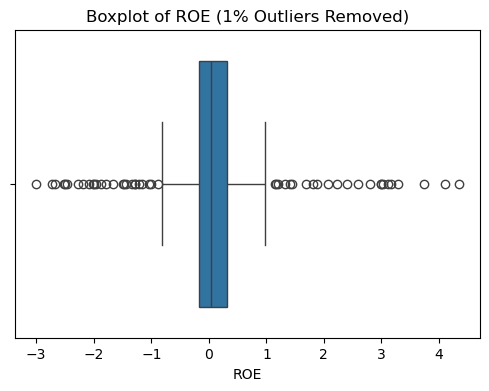

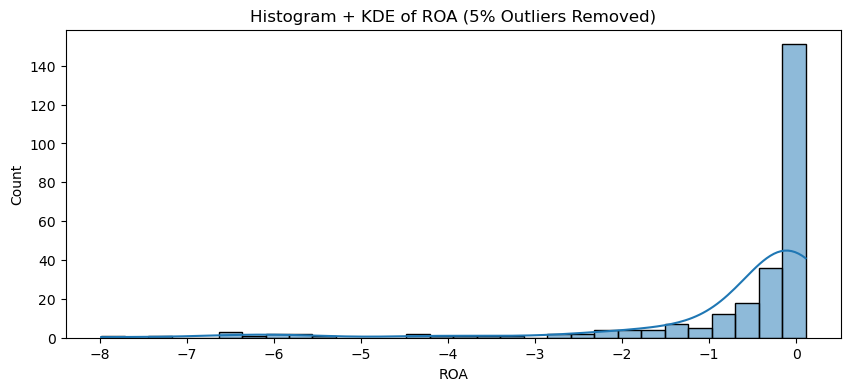

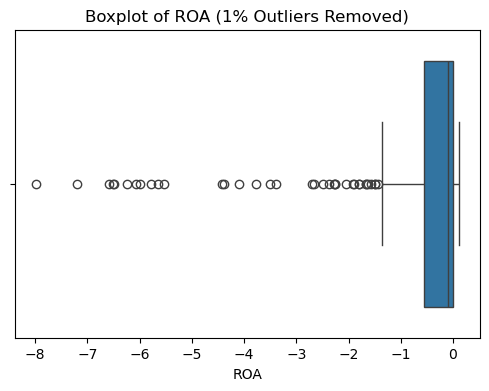


Correlations between financial metrics (5% Outliers Removed):
metric_name  Net Income   Revenue       ROE       ROA
metric_name                                          
Net Income     1.000000  0.131553  0.166410  0.106334
Revenue        0.131553  1.000000 -0.110056  0.136552
ROE            0.166410 -0.110056  1.000000 -0.125609
ROA            0.106334  0.136552 -0.125609  1.000000


In [326]:
# --- Histogram and Boxplot with Outlier Removal ---
for metric in ['Net Income', 'Revenue', 'ROE', 'ROA']:
    # Remove 1% of outliers
    lower_bound = edf[metric].quantile(0.05)
    upper_bound = edf[metric].quantile(0.95)
    trimmed_data = edf[(edf[metric] >= lower_bound) & (edf[metric] <= upper_bound)][metric].dropna()

    # Plot histogram with KDE
    plt.figure(figsize=(10, 4))
    sns.histplot(trimmed_data, kde=True, bins=30)
    plt.title(f'Histogram + KDE of {metric} (5% Outliers Removed)')
    plt.show()

    # Plot boxplot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=trimmed_data)
    plt.title(f'Boxplot of {metric} (1% Outliers Removed)')
    plt.show()

# --- Correlations with Outlier Removal ---
print("\nCorrelations between financial metrics (5% Outliers Removed):")
trimmed_edf = edf.copy()
for metric in ['Net Income', 'Revenue', 'ROE', 'ROA']:
    lower_bound = edf[metric].quantile(0.01)
    upper_bound = edf[metric].quantile(0.99)
    trimmed_edf = trimmed_edf[(trimmed_edf[metric] >= lower_bound) & (trimmed_edf[metric] <= upper_bound)]

print(trimmed_edf[['Net Income', 'Revenue', 'ROE', 'ROA']].corr())

In [327]:
from scipy.stats import ttest_ind, mannwhitneyu
from IPython.display import display, Markdown
from scipy.stats import pearsonr

### Hypothesis Test 1a: Pearson Correlation Test of Accrued Liabiilties (Current) and Risk Flag

- Null Hypothesis (H₀): There is no linear correlation between Accrued Liabilities (Current) and the Risk Flag (binary: 1 = High Risk, 0 = Low Risk).
- Alternative Hypothesis (H₁): There is a linear correlation between Accrued Liabilities (Current) and the Risk Flag.

In [328]:
corr_df = edf.dropna(subset=['Accrued Liabilities (Current)', 'Risk Flag'])

x = corr_df['Accrued Liabilities (Current)']
y = corr_df['Risk Flag']  # Assumes binary (0 = low risk, 1 = high risk)

# Perform Pearson correlation test
r, p_value = pearsonr(x, y)

# Format results in markdown
markdown_result = f"""
### Pearson Correlation Test 1a: Accrued Liabilities vs Risk Flag

| Metric           | Value        |
|------------------|--------------|
| Correlation (r)  | `{r:.4f}`    |
| p-value          | `{p_value:.4e}` |

**Conclusion**:
{"✅ Reject H₀ — statistically significant linear correlation." if p_value < 0.05 else "— Fail to reject H₀ — no significant linear correlation."}
"""

display(Markdown(markdown_result))



### Pearson Correlation Test 1a: Accrued Liabilities vs Risk Flag

| Metric           | Value        |
|------------------|--------------|
| Correlation (r)  | `-0.0125`    |
| p-value          | `6.8503e-01` |

**Conclusion**:
— Fail to reject H₀ — no significant linear correlation.


### Hypothesis Test 1b. (after removing 1% outliers): Pearson Correlation Test of Accrued Liabiilties (Current) and Risk Flag


In [329]:
# Remove 1% of outliers from 'Accrued Liabilities (Current)'
lower_bound = x.quantile(0.01)
upper_bound = x.quantile(0.99)
filtered_corr_df = corr_df[(x >= lower_bound) & (x <= upper_bound)]

# Update x and y after filtering
x_filtered = filtered_corr_df['Accrued Liabilities (Current)']
y_filtered = filtered_corr_df['Risk Flag']

# Perform Pearson correlation test on filtered data
r_filtered, p_value_filtered = pearsonr(x_filtered, y_filtered)

# Format results in markdown
markdown_result_filtered = f"""
### Pearson Correlation Test 1b: Accrued Liabilities vs Risk Flag (After Removing 1% Outliers)

| Metric           | Value        |
|------------------|--------------|
| Correlation (r)  | `{r_filtered:.4f}`    |
| p-value          | `{p_value_filtered:.4e}` |

**Conclusion**:
{"✅ Reject H₀ — statistically significant linear correlation." if p_value_filtered < 0.05 else "— Fail to reject H₀ — no significant linear correlation."}
"""

display(Markdown(markdown_result_filtered))


### Pearson Correlation Test 1b: Accrued Liabilities vs Risk Flag (After Removing 1% Outliers)

| Metric           | Value        |
|------------------|--------------|
| Correlation (r)  | `-0.1596`    |
| p-value          | `2.3226e-07` |

**Conclusion**:
✅ Reject H₀ — statistically significant linear correlation.


### Interpretation
The correlation coefficient r = -0.1596 indicates a weak negative linear relationship between Accrued Liabilities (Current) and the Risk Flag.

The p-value = 2.32e-07 is well below 0.05, meaning the correlation is statistically significant, even after trimming 1% outliers.

Since the correlation is negative, it suggests that as accrued liabilities increase, the likelihood of being flagged as high risk slightly decreases in this dataset.

This may be counterintuitive and could imply:
- Some low-risk firms have higher operational scale and liabilities.
- Accrued liabilities alone are not a strong predictor of financial risk, or
- The relationship may be non-linear or influenced by other confounding variables (e.g., revenue size, sector).

### Hypothesis Test 2a: Difference in Profit Margin between Risk Groups
- H₀: There is no difference in Profit Margin between high-risk and low-risk firms.
- H₁: High-risk firms have significantly lower Profit Margins.

Test: Independent samples t-test or Mann-Whitney U (non-parametric).


In [330]:
from scipy.stats import ttest_ind, mannwhitneyu
from IPython.display import display, Markdown

# Drop rows with missing Profit Margin or Risk Category
df_valid = edf.dropna(subset=['Profit Margin', 'Risk Category'])

# Split the data into Low Risk and High Risk groups
low_risk = df_valid[df_valid['Risk Category'] == 'Low Risk']['Profit Margin']
high_risk = df_valid[df_valid['Risk Category'] == 'High Risk']['Profit Margin']

# Welch’s t-test (does not assume equal variances)
t_stat, p_ttest = ttest_ind(low_risk, high_risk, equal_var=False)

# Mann-Whitney U Test (non-parametric)
u_stat, p_mannwhitney = mannwhitneyu(low_risk, high_risk, alternative='two-sided')

# Calculate mean Profit Margin for both groups
mean_low = low_risk.mean()
mean_high = high_risk.mean()

# Markdown table with results
markdown_result = f"""
### Hypothesis Test 2a: Difference in Profit Margin between Risk Groups

| Test                   | Statistic         | p-value           | Conclusion                   |
|------------------------|-------------------|-------------------|------------------------------|
| **t-test (Welch)**     | t = `{t_stat:.2f}` | `{p_ttest:.2e}`   | {"✅ Significant" if p_ttest < 0.05 else "— Not significant"} |
| **Mann-Whitney U test**| U = `{u_stat:.2f}` | `{p_mannwhitney:.2e}` | {"✅ Significant" if p_mannwhitney < 0.05 else "— Not significant"} |

**Mean Profit Margin**:
- Low Risk: `{mean_low:.4f}`
- High Risk: `{mean_high:.4f}`
"""

display(Markdown(markdown_result))



### Hypothesis Test 2a: Difference in Profit Margin between Risk Groups

| Test                   | Statistic         | p-value           | Conclusion                   |
|------------------------|-------------------|-------------------|------------------------------|
| **t-test (Welch)**     | t = `1.28` | `2.05e-01`   | — Not significant |
| **Mann-Whitney U test**| U = `304.00` | `5.69e-02` | — Not significant |

**Mean Profit Margin**:
- Low Risk: `0.0803`
- High Risk: `-316.9035`


### Hypothesis Test 2b. (after removing 1% outliers): Profit Margin vs Risk

In [331]:
pm_series = edf['Profit Margin'].dropna()

# Remove outliers based on the 1st and 99th percentiles
lower_bound = pm_series.quantile(0.01)
upper_bound = pm_series.quantile(0.99)

# Filter the dataframe
filtered_df = edf[
    (edf['Profit Margin'] >= lower_bound) &
    (edf['Profit Margin'] <= upper_bound)
].dropna(subset=['Risk Category'])

# Step 2: Split by risk category
low_risk = filtered_df[filtered_df['Risk Category'] == 'Low Risk']['Profit Margin']
high_risk = filtered_df[filtered_df['Risk Category'] == 'High Risk']['Profit Margin']

# Step 3: Perform statistical tests
t_stat, p_ttest = ttest_ind(low_risk, high_risk, equal_var=False)
u_stat, p_mannwhitney = mannwhitneyu(low_risk, high_risk, alternative='two-sided')

# Step 4: Calculate group means
mean_low = low_risk.mean()
mean_high = high_risk.mean()

# Step 5: Present results
markdown_result = f"""
### Hypothesis Test 2b (after removing 1% outliers): Profit Margin vs Risk

| Test                   | Statistic         | p-value           | Conclusion                   |
|------------------------|-------------------|-------------------|------------------------------|
| **t-test (Welch)**     | t = `{t_stat:.2f}` | `{p_ttest:.2e}`   | {"✅ Significant" if p_ttest < 0.05 else "— Not significant"} |
| **Mann-Whitney U test**| U = `{u_stat:.2f}` | `{p_mannwhitney:.2e}` | {"✅ Significant" if p_mannwhitney < 0.05 else "— Not significant"} |

**Mean Profit Margin (after trimming outliers)**:
- Low Risk: `{mean_low:.4f}`
- High Risk: `{mean_high:.4f}`
"""

display(Markdown(markdown_result))



### Hypothesis Test 2b (after removing 1% outliers): Profit Margin vs Risk

| Test                   | Statistic         | p-value           | Conclusion                   |
|------------------------|-------------------|-------------------|------------------------------|
| **t-test (Welch)**     | t = `2.74` | `7.12e-03`   | ✅ Significant |
| **Mann-Whitney U test**| U = `298.00` | `4.91e-02` | ✅ Significant |

**Mean Profit Margin (after trimming outliers)**:
- Low Risk: `0.0803`
- High Risk: `-30.8974`


### Conclusions

Both tests show statistically significant differences in Profit Margin between risk categories at the α = 0.05 level.

- The t-test suggests a mean difference, assuming approximate normality.
- The Mann-Whitney U test (non-parametric) supports the finding even without normality assumptions.

High Risk firms, on average, have extremely negative profit margins, whereas Low Risk firms are modestly profitable.

The reason your regression output is filled with nan and inf is likely due to extreme values (outliers) or multicollinearity / numerical instability in the variables, especially Net Income and Revenue.

### Hypothesis Test 3a: High Debt to Equity → Higher Risk

- H₀: Debt to Equity ratio has no effect on the Risk Flag (binary or ordinal variable).
- H₁: Higher Debt to Equity increases the likelihood of a positive Risk Flag.

Test: Logistic regression or t-test (depending on how Risk Flag is coded).

In [335]:
import statsmodels.api as sm

logit_df = edf.dropna(subset=['Debt to Equity', 'Risk Flag'])

# Define the independent variable and the target variable
X = logit_df[['Debt to Equity']]
X = sm.add_constant(X)  # Adds the intercept term
y = logit_df['Risk Flag']

# Fit logistic regression model
model = sm.Logit(y, X).fit(disp=False)

# Extract model parameters
coef = model.params['Debt to Equity']
p_value = model.pvalues['Debt to Equity']
odds_ratio = round(np.exp(coef), 4)

# Calculate 95% confidence interval for odds ratio
conf = model.conf_int()
lower_bound = np.exp(conf.loc['Debt to Equity'][0])
upper_bound = np.exp(conf.loc['Debt to Equity'][1])

# Display results in Markdown format
markdown_output = f"""
### Hypothesis Test 3a: Debt to Equity vs Risk Flag

| Metric                          | Value                          |
|---------------------------------|--------------------------------|
| **Coefficient (β)**             | `{coef:.4f}`                  |
| **Odds Ratio**                  | `{odds_ratio:.4f}`            |
| **95% Confidence Interval**     | [`{lower_bound:.4f}`, `{upper_bound:.4f}`] |
| **p-value**                     | `{p_value:.4f}` {"✅ Significant" if p_value < 0.05 else "— Not significant"} |

---

**Interpretation**:
- {"The effect of Debt to Equity on the probability of being high risk is statistically significant." if p_value < 0.05 else "There is no statistically significant effect of Debt to Equity on the probability of being high risk."}
- An increase of one unit in the Debt to Equity ratio multiplies the odds of being flagged as high risk by approximately `{odds_ratio:.4f}`.
"""

display(Markdown(markdown_output))



### Hypothesis Test 3a: Debt to Equity vs Risk Flag

| Metric                          | Value                          |
|---------------------------------|--------------------------------|
| **Coefficient (β)**             | `-0.0002`                  |
| **Odds Ratio**                  | `0.9998`            |
| **95% Confidence Interval**     | [`0.9857`, `1.0141`] |
| **p-value**                     | `0.9731` — Not significant |

---

**Interpretation**:
- There is no statistically significant effect of Debt to Equity on the probability of being high risk.
- An increase of one unit in the Debt to Equity ratio multiplies the odds of being flagged as high risk by approximately `0.9998`.


### Hypothesis Test 3b (After Removing 1% Outliers): Debt to Equity vs Risk Flag


In [336]:
# Remove outliers based on the 1st and 99th percentiles
lower_bound = logit_df['Debt to Equity'].quantile(0.01)
upper_bound = logit_df['Debt to Equity'].quantile(0.99)

# Filter the DataFrame to exclude outliers
filtered_logit_df = logit_df[(logit_df['Debt to Equity'] >= lower_bound) & (logit_df['Debt to Equity'] <= upper_bound)]

# Define the independent variable and the target variable
X_filtered = filtered_logit_df[['Debt to Equity']]
X_filtered = sm.add_constant(X_filtered)  # Adds the intercept term
y_filtered = filtered_logit_df['Risk Flag']

# Fit logistic regression model
filtered_model = sm.Logit(y_filtered, X_filtered).fit(disp=False)

# Extract model parameters
coef_filtered = filtered_model.params['Debt to Equity']
p_value_filtered = filtered_model.pvalues['Debt to Equity']
odds_ratio_filtered = round(np.exp(coef_filtered), 4)

# Calculate 95% confidence interval for odds ratio
conf_filtered = filtered_model.conf_int()
lower_bound_filtered = np.exp(conf_filtered.loc['Debt to Equity'][0])
upper_bound_filtered = np.exp(conf_filtered.loc['Debt to Equity'][1])

# Display results in Markdown format
markdown_output_filtered = f"""
### Hypothesis Test 3b (After Removing 1% Outliers): Debt to Equity vs Risk Flag

| Metric                          | Value                          |
|---------------------------------|--------------------------------|
| **Coefficient (β)**             | `{coef_filtered:.4f}`         |
| **Odds Ratio**                  | `{odds_ratio_filtered:.4f}`   |
| **95% Confidence Interval**     | [`{lower_bound_filtered:.4f}`, `{upper_bound_filtered:.4f}`] |
| **p-value**                     | `{p_value_filtered:.4f}` {"✅ Significant" if p_value_filtered < 0.05 else "— Not significant"} |

---

**Interpretation**:
- {"The effect of Debt to Equity on the probability of being high risk is statistically significant." if p_value_filtered < 0.05 else "There is no statistically significant effect of Debt to Equity on the probability of being high risk."}
- An increase of one unit in the Debt to Equity ratio multiplies the odds of being flagged as high risk by approximately `{odds_ratio_filtered:.4f}`.
"""

display(Markdown(markdown_output_filtered))



### Hypothesis Test 3b (After Removing 1% Outliers): Debt to Equity vs Risk Flag

| Metric                          | Value                          |
|---------------------------------|--------------------------------|
| **Coefficient (β)**             | `-0.0232`         |
| **Odds Ratio**                  | `0.9771`   |
| **95% Confidence Interval**     | [`0.8731`, `1.0934`] |
| **p-value**                     | `0.6864` — Not significant |

---

**Interpretation**:
- There is no statistically significant effect of Debt to Equity on the probability of being high risk.
- An increase of one unit in the Debt to Equity ratio multiplies the odds of being flagged as high risk by approximately `0.9771`.
